In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.impute import KNNImputer
from sklearn.linear_model import SGDRegressor, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.metrics import *
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

pd.set_option('display.max_column',500)
pd.set_option('display.max_row',500)

data = pd.read_csv('2016_Building_Energy_Benchmarking.csv')
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

## Exploratory Data Analysis

### Objectif :

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici les données et leur source. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

### Conseil de Douglas

Douglas : L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées.. 

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.

### Checklist de base
 

#### Analyse de Forme :
    - variables targets :
        SiteEUIWN(kBtu/sf) 
        GHGEmissionsIntensity
    
    - lignes et colonnes : 
        (3376, 46)
        
    - types de variables : 
        qualitatives 16 et quantitatives 30
        
    - Analyse des valeurs manquantes :
        beaucoup de données ( sauf 7 colonnes qui ont moins de 50% de données )
        plusieurs groupes :
            - 0% données manquantes ( date, années de construction, localisation, type de bâtiment... )
            - 0.14% - 0.27% de données manquantes ( émissions gaz à effet de serre, intensité de consommation d'énergie,...)
            - 0.27% - 0.60% de données manquantes ( la plus grande utilisation d'une propriété,zipcode )
            - 25% de données manquantes ( energy score )
            - > 25% de données manquantes ( les autres utilisations d'une propriété... )
            
  

#### Analyse de Fond :
    - Visualisation de la target 
    - Signification des variables 
    - Relation Variables / Target 

## Analyse de la forme des données

In [3]:
df = data.copy()

In [4]:
#nombre de lignes et colonnes
df.shape

(3376, 46)

In [5]:
df.dtypes

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

In [6]:
#types de variables
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

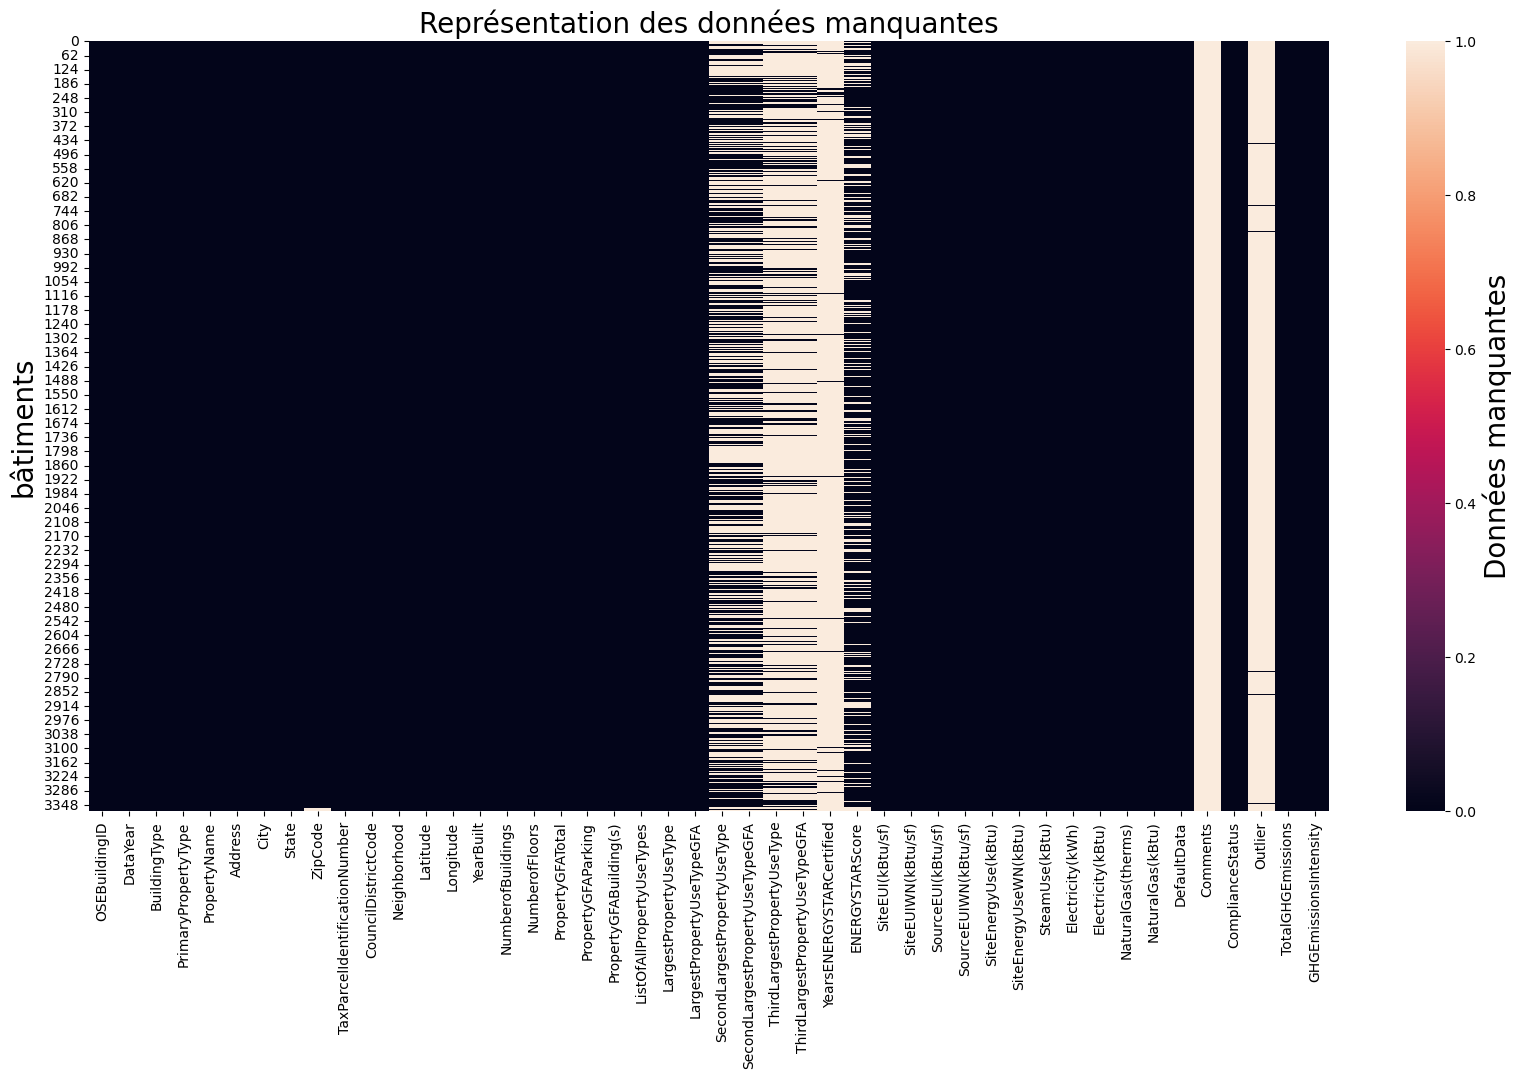

In [7]:
#valeurs manquantes
plt.figure(figsize=(20,10))
ax = sns.heatmap(df.isna())
plt.title('Représentation des données manquantes',fontsize=20)
ax.collections[0].colorbar.set_label("Données manquantes",fontsize=20)
plt.ylabel('bâtiments',fontsize=20)
plt.show()

In [8]:
(df.isna().sum()/df.shape[0]).sort_values()

OSEBuildingID                      0.000000
PropertyGFABuilding(s)             0.000000
PropertyGFAParking                 0.000000
PropertyGFATotal                   0.000000
NumberofFloors                     0.000000
YearBuilt                          0.000000
Longitude                          0.000000
Latitude                           0.000000
Neighborhood                       0.000000
DefaultData                        0.000000
CouncilDistrictCode                0.000000
ComplianceStatus                   0.000000
State                              0.000000
City                               0.000000
Address                            0.000000
PropertyName                       0.000000
PrimaryPropertyType                0.000000
BuildingType                       0.000000
DataYear                           0.000000
TaxParcelIdentificationNumber      0.000000
SiteEnergyUse(kBtu)                0.001481
SiteEnergyUseWN(kBtu)              0.001777
SiteEUIWN(kBtu/sf)              

## Analyse du Fond


In [9]:
for col in df.columns:
    print(col)
    print(df[str(col)].value_counts())
    print('-'*50)

OSEBuildingID
1        1
25062    1
24943    1
24948    1
24955    1
        ..
20985    1
20986    1
20987    1
20988    1
50226    1
Name: OSEBuildingID, Length: 3376, dtype: int64
--------------------------------------------------
DataYear
2016    3376
Name: DataYear, dtype: int64
--------------------------------------------------
BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64
--------------------------------------------------
PrimaryPropertyType
Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105


In [10]:
print(df['ThirdLargestPropertyUseType'].count())
print(df['ThirdLargestPropertyUseTypeGFA'].count())

#proportion = df['ThirdLargestPropertyUseType'].value_counts()
#plt.figure(figsize=[20,50])
#plt.title('La troisième plus grande utilisation d\'une propriété',fontsize=25)
#ax=sns.barplot(x=proportion.values,y=proportion.index)
#plt.grid(axis='x')
#ax.xaxis.set_ticks_position('top')
#plt.plot()

596
596


In [11]:
print(df['SecondLargestPropertyUseType'].count())
print(df['SecondLargestPropertyUseTypeGFA'].count())

1679
1679


In [12]:
print(df['LargestPropertyUseType'].count())
print(df['LargestPropertyUseTypeGFA'].count())

3356
3356


In [13]:
#affichons les colonnes ayant une 3eme plus grande utilisation mais pas de 2eme ou 1ere grande utilisation

df_third_use_type = df.loc[df['ThirdLargestPropertyUseType'].notnull()]

df_third_use_type.loc[(df['SecondLargestPropertyUseType'].isnull()) | (df['LargestPropertyUseType'].isnull())]

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, Comments, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []

In [14]:
#affichons les colonnes ayant une 3eme plus grande utilisation GFA mais pas de 2eme ou 1ere grande utilisation GFA

df_third_use_gfa = df.loc[df['ThirdLargestPropertyUseTypeGFA'].notnull()]

df_third_use_gfa.loc[(df['SecondLargestPropertyUseTypeGFA'].isnull()) | (df['LargestPropertyUseTypeGFA'].isnull())]

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, Comments, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []

In [15]:
#affichons les colonnes ayant une 2eme plus grande utilisation mais pas 1ere grande utilisation

df_second_use_type = df.loc[df['SecondLargestPropertyUseType'].notnull()]

df_second_use_type.loc[df['LargestPropertyUseType'].isnull()]

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, Comments, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []

In [16]:
#affichons les colonnes ayant une 2eme plus grande utilisation GFA mais pas 1ere grande utilisation GFA

df_second_use_gfa = df.loc[df['SecondLargestPropertyUseTypeGFA'].notnull()]

df_second_use_gfa.loc[df['LargestPropertyUseTypeGFA'].isnull()]

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, Comments, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []

In [17]:
df.loc[(df['LargestPropertyUseType']==df['SecondLargestPropertyUseType']) |
       (df['LargestPropertyUseType']==df['ThirdLargestPropertyUseType']) |
       (df['SecondLargestPropertyUseType']==df['ThirdLargestPropertyUseType']),
       ['OSEBuildingID','LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType',
        'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']]

OSEBuildingID     LargestPropertyUseType SecondLargestPropertyUseType  \
356             500  Supermarket/Grocery Store                      Parking   
542             732  Supermarket/Grocery Store                      Parking   
594             796                     Office                      Parking   
2957          27652        Multifamily Housing                      Parking   
3084          29069      Senior Care Community        Senior Care Community   
3132          40034                     Office                       Office   

     ThirdLargestPropertyUseType  LargestPropertyUseTypeGFA  \
356                      Parking                   121087.0   
542                      Parking                   168735.0   
594                      Parking                   245240.0   
2957                     Parking                   188294.0   
3084                         NaN                   132284.0   
3132                         NaN                    31845.0   

      SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  
356                               0.0                             0.0  
542                               0.0                             0.0  
594                            5616.0                          5616.0  
2957                          23385.0                         23385.0  
3084                         132284.0                             NaN  
3132                          31845.0                             NaN

In [18]:
df.loc[(df['OSEBuildingID']== 500) | (df['OSEBuildingID']== 732),
       ['SecondLargestPropertyUseType','ThirdLargestPropertyUseType']] = 'None'

In [19]:
df.loc[df['OSEBuildingID']==796,'ThirdLargestPropertyUseTypeGFA'] = 0
df.loc[df['OSEBuildingID']==796,'ThirdLargestPropertyUseType'] = 'None'

In [20]:
df.loc[df['OSEBuildingID']==27652,'ThirdLargestPropertyUseTypeGFA'] = 0
df.loc[df['OSEBuildingID']==27652,'ThirdLargestPropertyUseType'] = 'None'

In [21]:
df.loc[df['OSEBuildingID']==29069,'SecondLargestPropertyUseTypeGFA'] = 0
df.loc[df['OSEBuildingID']==29069,'SecondLargestPropertyUseType'] = 'None'

In [22]:
df.loc[df['OSEBuildingID']==40034,'SecondLargestPropertyUseTypeGFA'] = 0
df.loc[df['OSEBuildingID']==40034,'SecondLargestPropertyUseType'] = 'None'

In [23]:
df.loc[df['LargestPropertyUseTypeGFA']<=0 ,'LargestPropertyUseType']

Series([], Name: LargestPropertyUseType, dtype: object)

In [24]:
df.loc[df['SecondLargestPropertyUseTypeGFA']<=0 ,'SecondLargestPropertyUseType']

59            Parking
80      Swimming Pool
90            Parking
91            Parking
116           Parking
155           Parking
262     Swimming Pool
319           Parking
321           Parking
322           Parking
324           Parking
356              None
364           Parking
367           Parking
384             Other
386           Parking
388           Parking
392           Parking
401           Parking
418           Parking
447           Parking
502           Parking
536           Parking
540           Parking
542              None
566      Retail Store
580           Parking
586           Parking
592           Parking
598           Parking
695           Parking
832     Swimming Pool
875           Parking
878           Parking
886           Parking
900           Parking
949           Parking
966           Parking
992     Swimming Pool
995           Parking
998           Parking
1033          Parking
1038          Parking
1058          Parking
1065          Parking
1086      

In [25]:
df.loc[df['SecondLargestPropertyUseTypeGFA']<=0 ,'SecondLargestPropertyUseType'] = 'None'
df.loc[df['SecondLargestPropertyUseTypeGFA']<=0 ,'SecondLargestPropertyUseTypeGFA'] = 0

In [26]:
df.loc[df['ThirdLargestPropertyUseTypeGFA']<=0 ,'ThirdLargestPropertyUseType']

4       Swimming Pool
16      Swimming Pool
49      Swimming Pool
144     Swimming Pool
331           Parking
356              None
400           Parking
403      Retail Store
501     Swimming Pool
542              None
548           Parking
594              None
720     Swimming Pool
799     Swimming Pool
827           Parking
828           Parking
844     Swimming Pool
877     Swimming Pool
878     Swimming Pool
1050    Swimming Pool
1079    Swimming Pool
1606    Swimming Pool
1658          Parking
1673          Parking
1680    Swimming Pool
1777          Parking
1790    Swimming Pool
1908          Parking
1949          Parking
2262          Parking
2354    Swimming Pool
2362          Parking
2399    Swimming Pool
2574    Swimming Pool
2609    Swimming Pool
2724    Swimming Pool
2804          Parking
2852    Swimming Pool
2895    Swimming Pool
2919          Parking
2922    Swimming Pool
2957             None
2969    Swimming Pool
3045          Parking
3066          Parking
3155    Sw

In [27]:
df.loc[df['ThirdLargestPropertyUseTypeGFA']<=0 ,'ThirdLargestPropertyUseType'] = 'None'
df.loc[df['ThirdLargestPropertyUseTypeGFA']<=0 ,'ThirdLargestPropertyUseTypeGFA'] = 0

In [28]:
df.loc[df['LargestPropertyUseType'].isnull(),'LargestPropertyUseType'] = 'None'
df.loc[df['LargestPropertyUseTypeGFA'].isnull(),'LargestPropertyUseTypeGFA'] = 0

df.loc[df['SecondLargestPropertyUseType'].isnull(),'SecondLargestPropertyUseType'] = 'None'
df.loc[df['SecondLargestPropertyUseTypeGFA'].isnull(),'SecondLargestPropertyUseTypeGFA'] = 0

df.loc[df['ThirdLargestPropertyUseType'].isnull(),'ThirdLargestPropertyUseType'] = 'None'
df.loc[df['ThirdLargestPropertyUseTypeGFA'].isnull(),'ThirdLargestPropertyUseTypeGFA'] = 0

In [29]:
(df.isna().sum()/df.shape[0]).sort_values()

OSEBuildingID                      0.000000
ComplianceStatus                   0.000000
DefaultData                        0.000000
ThirdLargestPropertyUseTypeGFA     0.000000
ThirdLargestPropertyUseType        0.000000
SecondLargestPropertyUseTypeGFA    0.000000
SecondLargestPropertyUseType       0.000000
LargestPropertyUseType             0.000000
PropertyGFABuilding(s)             0.000000
PropertyGFAParking                 0.000000
PropertyGFATotal                   0.000000
NumberofFloors                     0.000000
YearBuilt                          0.000000
LargestPropertyUseTypeGFA          0.000000
Latitude                           0.000000
DataYear                           0.000000
Neighborhood                       0.000000
CouncilDistrictCode                0.000000
TaxParcelIdentificationNumber      0.000000
BuildingType                       0.000000
State                              0.000000
City                               0.000000
Address                         

In [35]:
df['TotalSurface'] = df['LargestPropertyUseTypeGFA'] + df['SecondLargestPropertyUseTypeGFA'] + df['ThirdLargestPropertyUseTypeGFA']

In [36]:
df.loc[df['TotalSurface'] != df['PropertyGFATotal'],['PropertyGFATotal','TotalSurface']]

PropertyGFATotal  TotalSurface
2               956110      756493.0
4               175580      191454.0
5                97288       88830.0
6                83008       81352.0
9                63712       56132.0
...                ...           ...
3360             20616       19841.0
3364             16795       16229.0
3368             20050       19613.0
3374             14101       13586.0
3375             18258       17379.0

[1781 rows x 2 columns]

In [37]:
df.loc[df['PropertyGFATotal'].isna()]

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, Comments, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity, TotalSurface]
Index: []

In [38]:
df.loc[df['PropertyGFATotal']<=0]

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), DefaultData, Comments, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity, TotalSurface]
Index: []

In [39]:
df.loc[df['TotalSurface'] > df['PropertyGFATotal'],['PropertyGFATotal','TotalSurface']]

PropertyGFATotal  TotalSurface
4               175580      191454.0
11              333176      336640.0
13              315952      353111.0
14               92190       92590.0
15              412000      414987.0
...                ...           ...
3352             25442       34164.0
3353             63825       71241.0
3355             86045       87854.0
3357            208136      212938.0
3359             68072       68916.0

[776 rows x 2 columns]

In [40]:
df['TotalSurface_PropertyGFATotal'] = ((df['PropertyGFATotal'] - df['TotalSurface'])/df['TotalSurface'])*100

In [41]:
df.shape

(3376, 48)

In [42]:
df.drop(df[(df['TotalSurface_PropertyGFATotal']>=20) | (df['TotalSurface_PropertyGFATotal']<=-20)].index,inplace=True)

In [43]:
df.shape

(2774, 48)

In [44]:
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [45]:
df = df[~df['BuildingType'].str.contains("Multifamily")]
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

In [46]:
df['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Library', 'Courthouse', 'Other', 'K-12 School',
       'College/University', 'Automobile Dealership', 'Office',
       'Self-Storage Facility', 'Other - Mall', 'Senior Care Community',
       'Medical Office', 'Retail Store',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital',
       'Hospital (General Medical & Surgical)', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Museum', 'Distribution Center',
       'Parking', 'Multifamily Housing', 'Worship Facility', 'Restaurant',
       'Data Center', 'Laboratory', 'Supermarket/Grocery Store',
       'Urgent Care/Clinic/Other Outpatient', 'Other - Services',
       'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Manufacturing/Industrial Plant',
       'Other - Recreation', 'Lifestyle Center',
       'Other - Publi

In [47]:
df = df[~df['LargestPropertyUseType'].str.contains("Multifamily")]
df['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Library', 'Courthouse', 'Other', 'K-12 School',
       'College/University', 'Automobile Dealership', 'Office',
       'Self-Storage Facility', 'Other - Mall', 'Senior Care Community',
       'Medical Office', 'Retail Store',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital',
       'Hospital (General Medical & Surgical)', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Museum', 'Distribution Center',
       'Parking', 'Worship Facility', 'Restaurant', 'Data Center',
       'Laboratory', 'Supermarket/Grocery Store',
       'Urgent Care/Clinic/Other Outpatient', 'Other - Services',
       'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Manufacturing/Industrial Plant',
       'Other - Recreation', 'Lifestyle Center',
       'Other - Public Services', 'Social/Me

In [48]:
df['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'K-12 School', 'University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility',
       'Large Office', 'Mixed Use Property', 'Senior Care Community',
       'Medical Office', 'Retail Store', 'Residence Hall', 'Hospital',
       'Warehouse', 'Distribution Center', 'Worship Facility',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'Office'], dtype=object)

In [49]:
df.shape

(1393, 48)

In [50]:
df['ComplianceStatus'].value_counts()

Compliant                       1284
Error - Correct Default Data      84
Missing Data                      14
Non-Compliant                     11
Name: ComplianceStatus, dtype: int64

In [51]:
df = df[~df['ComplianceStatus'].str.contains("Error - Correct Default Data|Missing Data|Non-Compliant")]

In [52]:
df.shape

(1284, 48)

In [53]:
df.loc[df['Outlier'].notna(),'Outlier'].value_counts()

Series([], Name: Outlier, dtype: int64)

In [54]:
df = df[~df['Outlier'].str.contains("outlier",na=False)]

In [55]:
df.shape

(1284, 48)

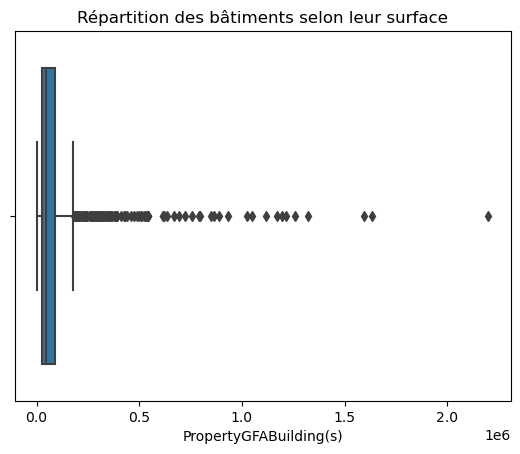

In [56]:
plt.title('Répartition des bâtiments selon leur surface')
sns.boxplot(df.loc[df['NumberofBuildings']==1,'PropertyGFABuilding(s)']);

In [57]:
df.loc[(df['NumberofBuildings']==1) & (df['PropertyGFABuilding(s)']>150000),'PropertyGFABuilding(s)'].count()

162

In [58]:
df.drop(df[(df['NumberofBuildings']==1) & (df['PropertyGFABuilding(s)']>150000)].index,inplace=True)

In [59]:
df.loc[(df['NumberofBuildings']==1) & (df['PropertyGFABuilding(s)']>150000),'PropertyGFABuilding(s)'].count()

0

In [60]:
df.shape

(1122, 48)

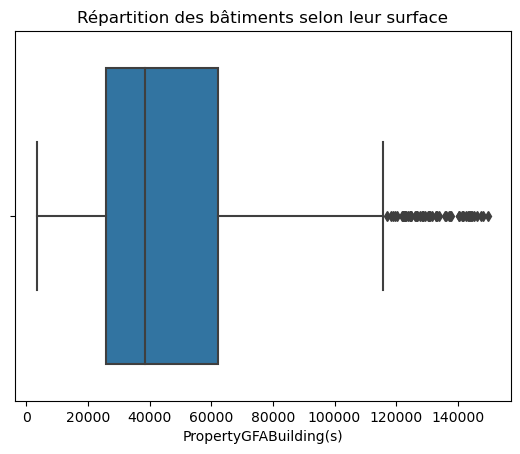

In [61]:
plt.title('Répartition des bâtiments selon leur surface')
sns.boxplot(df.loc[df['NumberofBuildings']==1,'PropertyGFABuilding(s)']);

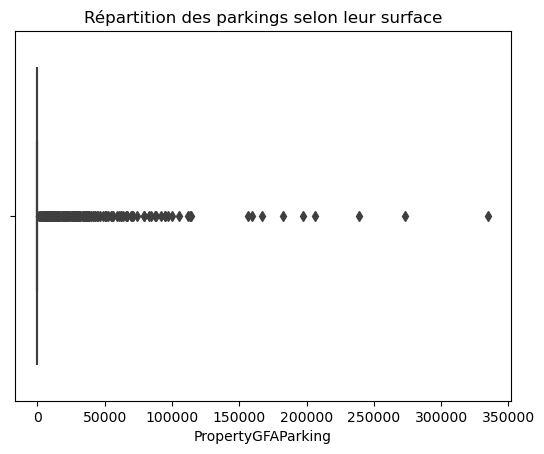

In [62]:
plt.title('Répartition des parkings selon leur surface');
sns.boxplot(df['PropertyGFAParking']);

In [63]:
df['somme'] = df['PropertyGFAParking'] + df['PropertyGFABuilding(s)']

In [64]:
df.loc[df['PropertyGFATotal'] != df['somme'],['PropertyGFATotal','somme']]

Empty DataFrame
Columns: [PropertyGFATotal, somme]
Index: []

In [65]:
#supprimons les colonnes que nous avons créées.
df.drop(columns=['TotalSurface','TotalSurface_PropertyGFATotal','somme'],inplace=True)

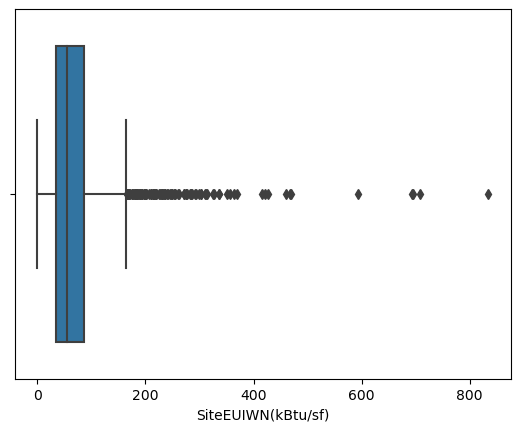

In [66]:
sns.boxplot(df['SiteEUIWN(kBtu/sf)']);

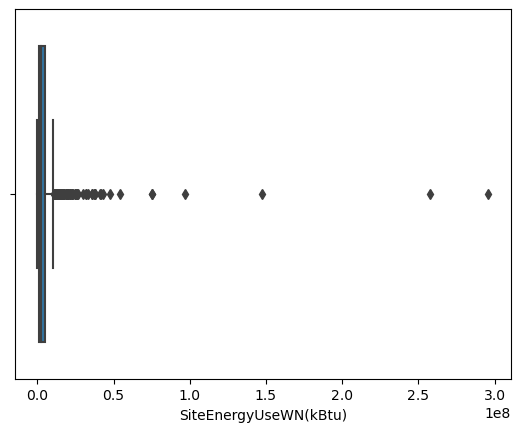

In [67]:
sns.boxplot(df['SiteEnergyUseWN(kBtu)']);

In [68]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [69]:
colonnes_sup=['OSEBuildingID','DataYear','PropertyName','Address','City','State','ZipCode',
              'TaxParcelIdentificationNumber','CouncilDistrictCode','ListOfAllPropertyUseTypes',
              'YearsENERGYSTARCertified','Electricity(kWh)','Electricity(kBtu)','NaturalGas(therms)',
              'DefaultData','Comments','ComplianceStatus','Outlier','SourceEUI(kBtu/sf)',
              'SourceEUIWN(kBtu/sf)','SiteEUI(kBtu/sf)','SiteEnergyUse(kBtu)',
              'SiteEnergyUseWN(kBtu)','TotalGHGEmissions','SecondLargestPropertyUseType',
              'ThirdLargestPropertyUseType','LargestPropertyUseType']

In [70]:
df.drop(columns=colonnes_sup,inplace=True)

In [71]:
df.head()

BuildingType PrimaryPropertyType Neighborhood  Latitude  Longitude  \
0      NonResidential               Hotel     DOWNTOWN  47.61220 -122.33799   
1      NonResidential               Hotel     DOWNTOWN  47.61317 -122.33393   
3      NonResidential               Hotel     DOWNTOWN  47.61412 -122.33664   
4      NonResidential               Hotel     DOWNTOWN  47.61375 -122.34047   
5  Nonresidential COS               Other     DOWNTOWN  47.61623 -122.33657   

   YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0       1927                1.0              12             88434   
1       1996                1.0              11            103566   
3       1926                1.0              10             61320   
4       1980                1.0              18            175580   
5       1999                1.0               2             97288   

   PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
0                   0                   88434                    88434.0   
1               15064                   88502                    83880.0   
3                   0                   61320                    61320.0   
4               62000                  113580                   123445.0   
5               37198                   60090                    88830.0   

   SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
0                              0.0                             0.0   
1                          15064.0                          4622.0   
3                              0.0                             0.0   
4                          68009.0                             0.0   
5                              0.0                             0.0   

   ENERGYSTARScore  SiteEUIWN(kBtu/sf)  SteamUse(kBtu)  NaturalGas(kBtu)  \
0             60.0           84.300003      2003882.00         1276453.0   
1             61.0           97.900002            0.00         5145082.0   
3             56.0          113.300003      2214446.25         1811213.0   
4             75.0          118.699997            0.00         8803998.0   
5              NaN          141.600006            0.00         4715182.0   

   GHGEmissionsIntensity  
0                   2.83  
1                   2.86  
3                   4.67  
4                   2.88  
5                   3.10

In [72]:
df.shape

(1122, 19)

[]

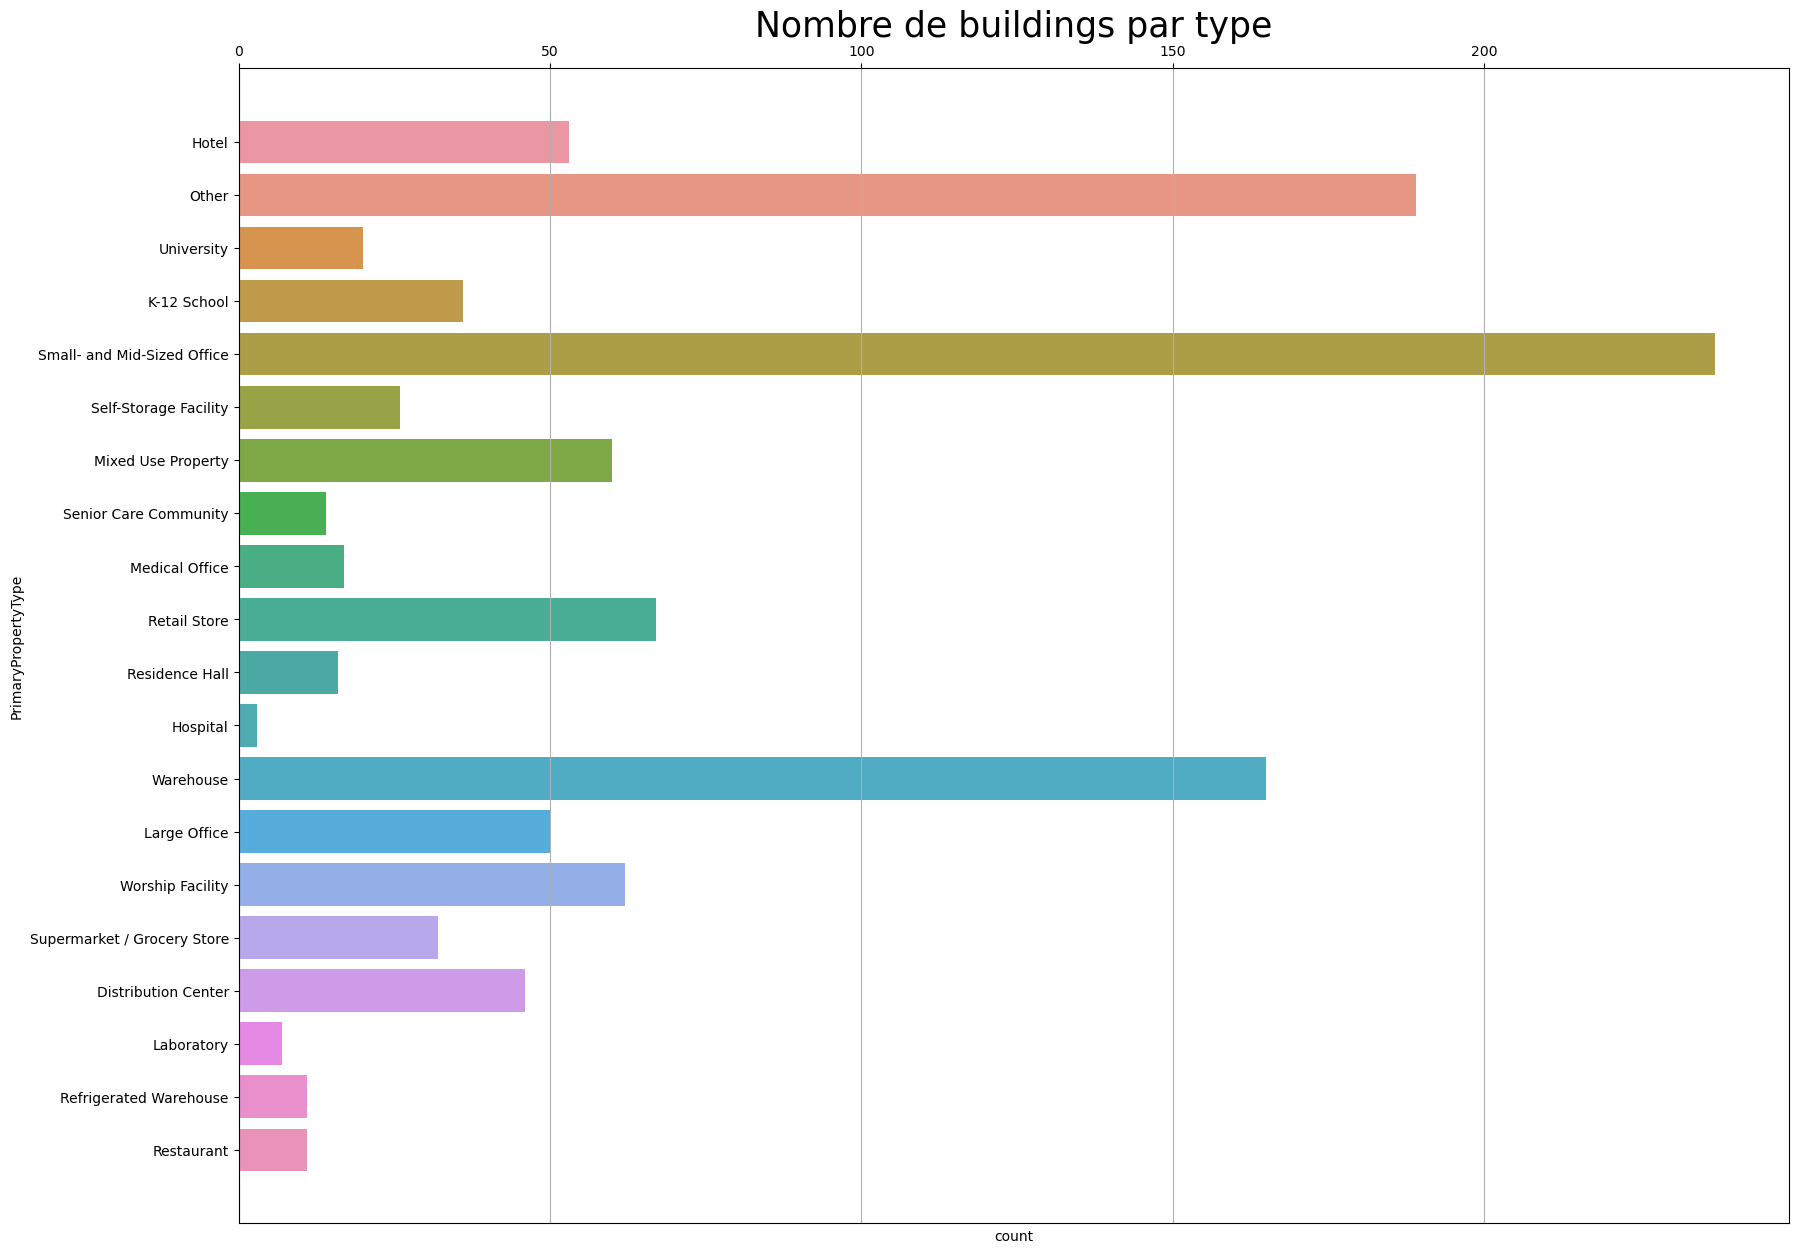

In [73]:
plt.figure(figsize=[20,15])
plt.title('Nombre de buildings par type',fontsize=25)
ax=sns.countplot(y=df['PrimaryPropertyType'])
plt.grid(axis='x')
ax.xaxis.set_ticks_position('top')
plt.plot()

In [74]:
df.loc[df['NumberofBuildings']==0,:]

BuildingType          PrimaryPropertyType           Neighborhood  \
63        NonResidential               Medical Office                   EAST   
76        NonResidential  Small- and Mid-Sized Office  MAGNOLIA / QUEEN ANNE   
160       NonResidential                    Warehouse       GREATER DUWAMISH   
201       NonResidential                 Large Office               DOWNTOWN   
264       NonResidential           Mixed Use Property       GREATER DUWAMISH   
278       NonResidential                 Large Office               DOWNTOWN   
280       NonResidential                        Hotel               DOWNTOWN   
291       NonResidential                        Other               DOWNTOWN   
358   Nonresidential COS                        Other               DELRIDGE   
365       NonResidential  Supermarket / Grocery Store              NORTHWEST   
417       NonResidential                        Other                  North   
429       NonResidential           Mixed Use Property             LAKE UNION   
433       NonResidential                        Other       GREATER DUWAMISH   
477       NonResidential                 Large Office       GREATER DUWAMISH   
481       NonResidential  Small- and Mid-Sized Office                   EAST   
494       NonResidential                 Retail Store               DELRIDGE   
544       NonResidential                    Warehouse  MAGNOLIA / QUEEN ANNE   
608       NonResidential                    Warehouse       GREATER DUWAMISH   
809       NonResidential                   Laboratory               DOWNTOWN   
1244      NonResidential                        Other                   EAST   
1317      NonResidential                        Other               DOWNTOWN   
1606  Nonresidential COS                        Other                  NORTH   
2054      NonResidential             Worship Facility              NORTHWEST   
2115      NonResidential  Supermarket / Grocery Store              NORTHWEST   
2188      NonResidential       Refrigerated Warehouse       GREATER DUWAMISH   
2214      NonResidential  Small- and Mid-Sized Office       GREATER DUWAMISH   
2382      NonResidential                   Restaurant             LAKE UNION   
2407      NonResidential           Mixed Use Property               DOWNTOWN   
2441      NonResidential  Small- and Mid-Sized Office               DOWNTOWN   
2564      NonResidential                 Retail Store                   EAST   
2631      NonResidential  Small- and Mid-Sized Office             LAKE UNION   
2708      NonResidential  Small- and Mid-Sized Office               DOWNTOWN   
2747      NonResidential  Small- and Mid-Sized Office               DOWNTOWN   
2782  Nonresidential COS           Mixed Use Property                   EAST   
3108      NonResidential                 Large Office               DOWNTOWN   
3121      NonResidential                 Retail Store                   EAST   
3155  Nonresidential COS                        Other                CENTRAL   
3205      NonResidential                   Laboratory             LAKE UNION   
3232  Nonresidential COS                        Other  MAGNOLIA / QUEEN ANNE   
3259      NonResidential  Small- and Mid-Sized Office                   EAST   

       Latitude   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
63    47.612440 -122.321400       1965                0.0               3   
76    47.623910 -122.348370       1986                0.0               2   
160   47.575070 -122.357470       1916                0.0               4   
201   47.617570 -122.351220       1968                0.0               3   
264   47.528710 -122.294430       1970                0.0               1   
278   47.610050 -122.336100       1926                0.0              10   
280   47.609960 -122.335720       1973                0.0              19   
291   47.611850 -122.334210       1996                0.0               4   
358   47.565480 -122.353780       1955

In [75]:
df.loc[df['NumberofBuildings']==0,'NumberofBuildings']=1

In [76]:
df.loc[df['NumberofBuildings']==0,:]

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, Neighborhood, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), LargestPropertyUseTypeGFA, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseTypeGFA, ENERGYSTARScore, SiteEUIWN(kBtu/sf), SteamUse(kBtu), NaturalGas(kBtu), GHGEmissionsIntensity]
Index: []

In [77]:
df.drop(df[(df['NumberofBuildings']==1) & (df['PropertyGFABuilding(s)']>150000)].index,inplace=True)

In [78]:
df.head()

BuildingType PrimaryPropertyType Neighborhood  Latitude  Longitude  \
0      NonResidential               Hotel     DOWNTOWN  47.61220 -122.33799   
1      NonResidential               Hotel     DOWNTOWN  47.61317 -122.33393   
3      NonResidential               Hotel     DOWNTOWN  47.61412 -122.33664   
4      NonResidential               Hotel     DOWNTOWN  47.61375 -122.34047   
5  Nonresidential COS               Other     DOWNTOWN  47.61623 -122.33657   

   YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0       1927                1.0              12             88434   
1       1996                1.0              11            103566   
3       1926                1.0              10             61320   
4       1980                1.0              18            175580   
5       1999                1.0               2             97288   

   PropertyGFAParking  PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
0                   0                   88434                    88434.0   
1               15064                   88502                    83880.0   
3                   0                   61320                    61320.0   
4               62000                  113580                   123445.0   
5               37198                   60090                    88830.0   

   SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
0                              0.0                             0.0   
1                          15064.0                          4622.0   
3                              0.0                             0.0   
4                          68009.0                             0.0   
5                              0.0                             0.0   

   ENERGYSTARScore  SiteEUIWN(kBtu/sf)  SteamUse(kBtu)  NaturalGas(kBtu)  \
0             60.0           84.300003      2003882.00         1276453.0   
1             61.0           97.900002            0.00         5145082.0   
3             56.0          113.300003      2214446.25         1811213.0   
4             75.0          118.699997            0.00         8803998.0   
5              NaN          141.600006            0.00         4715182.0   

   GHGEmissionsIntensity  
0                   2.83  
1                   2.86  
3                   4.67  
4                   2.88  
5                   3.10

In [79]:
import datetime

date = datetime.date.today()
year = date.strftime("%Y")
print(f"Current Year -> {year}")


Current Year -> 2023


In [80]:
type(year)

str

In [81]:
year_int = int(year)

In [82]:
type(year_int)

int

In [83]:
df['AgeBuilt'] = year_int - df['YearBuilt']

In [84]:
df.drop(columns=['YearBuilt'],inplace=True)

In [85]:
df.head()

BuildingType PrimaryPropertyType Neighborhood  Latitude  Longitude  \
0      NonResidential               Hotel     DOWNTOWN  47.61220 -122.33799   
1      NonResidential               Hotel     DOWNTOWN  47.61317 -122.33393   
3      NonResidential               Hotel     DOWNTOWN  47.61412 -122.33664   
4      NonResidential               Hotel     DOWNTOWN  47.61375 -122.34047   
5  Nonresidential COS               Other     DOWNTOWN  47.61623 -122.33657   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   
1                1.0              11            103566               15064   
3                1.0              10             61320                   0   
4                1.0              18            175580               62000   
5                1.0               2             97288               37198   

   PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
0                   88434                    88434.0   
1                   88502                    83880.0   
3                   61320                    61320.0   
4                  113580                   123445.0   
5                   60090                    88830.0   

   SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
0                              0.0                             0.0   
1                          15064.0                          4622.0   
3                              0.0                             0.0   
4                          68009.0                             0.0   
5                              0.0                             0.0   

   ENERGYSTARScore  SiteEUIWN(kBtu/sf)  SteamUse(kBtu)  NaturalGas(kBtu)  \
0             60.0           84.300003      2003882.00         1276453.0   
1             61.0           97.900002            0.00         5145082.0   
3             56.0          113.300003      2214446.25         1811213.0   
4             75.0          118.699997            0.00         8803998.0   
5              NaN          141.600006            0.00         4715182.0   

   GHGEmissionsIntensity  AgeBuilt  
0                   2.83        96  
1                   2.86        27  
3                   4.67        97  
4                   2.88        43  
5                   3.10        24

In [86]:
df.describe()

Latitude    Longitude  NumberofBuildings  NumberofFloors  \
count  1118.000000  1118.000000        1118.000000     1118.000000   
mean     47.616339  -122.333568           1.258497        2.855098   
std       0.050111     0.024609           3.544865        3.730218   
min      47.509590  -122.411820           1.000000        0.000000   
25%      47.580417  -122.344702           1.000000        1.000000   
50%      47.613255  -122.332635           1.000000        2.000000   
75%      47.653540  -122.321467           1.000000        3.000000   
max      47.733870  -122.261800         111.000000       99.000000   

       PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
count      1.118000e+03         1118.000000            1.118000e+03   
mean       7.010099e+04         6259.805009            6.384119e+04   
std        2.884807e+05        24261.696897            2.867286e+05   
min        1.128500e+04            0.000000            3.636000e+03   
25%        2.652225e+04            0.000000            2.612375e+04   
50%        4.090650e+04            0.000000            3.978750e+04   
75%        7.160925e+04            0.000000            6.496125e+04   
max        9.320156e+06       335109.000000            9.320156e+06   

       LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
count               1.118000e+03                      1118.000000   
mean                6.117189e+04                      7997.094454   
std                 2.869520e+05                     20273.976779   
min                 6.601000e+03                         0.000000   
25%                 2.366600e+04                         0.000000   
50%                 3.553950e+04                         0.000000   
75%                 6.067450e+04                      8986.500000   
max                 9.320156e+06                    441551.000000   

       ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUIWN(kBtu/sf)  \
count                     1118.000000       703.000000         1117.000000   
mean                      1129.210465        61.489331           75.631513   
std                       4338.386219        29.061720           78.574352   
min                          0.000000         1.000000            0.000000   
25%                          0.000000        41.000000           34.000000   
50%                          0.000000        67.000000           54.299999   
75%                          0.000000        86.000000           85.599998   
max                      84000.000000       100.000000          834.400024   

       SteamUse(kBtu)  NaturalGas(kBtu)  GHGEmissionsIntensity     AgeBuilt  
count    1.118000e+03      1.118000e+03            1118.000000  1118.000000  
mean     2.700770e+05      1.483893e+06               1.663023    63.676208  
std      4.790385e+06      5.662882e+06               2.266995    31.567818  
min      0.000000e+00      0.000000e+00              -0.020000     8.000000  
25%      0.000000e+00      0.000000e+00               0.370000    39.000000  
50%      0.000000e+00      4.922630e+05               0.925000    60.000000  
75%      0.000000e+00      1.302225e+06               1.980000    94.000000  
max      1.349435e+08      1.381912e+08              25.710000   123.000000

In [87]:
df['AgeRangeBuilt'] = pd.cut(x=df['AgeBuilt'], bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130])

In [88]:
df.loc[:,'AgeRangeBuilt']

0       (90, 100]
1        (20, 30]
3       (90, 100]
4        (40, 50]
5        (20, 30]
          ...    
3370     (40, 50]
3372     (10, 20]
3373     (40, 50]
3374     (30, 40]
3375     (80, 90]
Name: AgeRangeBuilt, Length: 1118, dtype: category
Categories (13, interval[int64, right]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] ... (90, 100] < (100, 110] < (110, 120] < (120, 130]]

In [89]:
df.dtypes

BuildingType                         object
PrimaryPropertyType                  object
Neighborhood                         object
Latitude                            float64
Longitude                           float64
NumberofBuildings                   float64
NumberofFloors                        int64
PropertyGFATotal                      int64
PropertyGFAParking                    int64
PropertyGFABuilding(s)                int64
LargestPropertyUseTypeGFA           float64
SecondLargestPropertyUseTypeGFA     float64
ThirdLargestPropertyUseTypeGFA      float64
ENERGYSTARScore                     float64
SiteEUIWN(kBtu/sf)                  float64
SteamUse(kBtu)                      float64
NaturalGas(kBtu)                    float64
GHGEmissionsIntensity               float64
AgeBuilt                              int64
AgeRangeBuilt                      category
dtype: object

In [90]:
df.drop(columns=['AgeBuilt'],inplace=True)

In [91]:
df.head()

BuildingType PrimaryPropertyType Neighborhood  Latitude  Longitude  \
0      NonResidential               Hotel     DOWNTOWN  47.61220 -122.33799   
1      NonResidential               Hotel     DOWNTOWN  47.61317 -122.33393   
3      NonResidential               Hotel     DOWNTOWN  47.61412 -122.33664   
4      NonResidential               Hotel     DOWNTOWN  47.61375 -122.34047   
5  Nonresidential COS               Other     DOWNTOWN  47.61623 -122.33657   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   
1                1.0              11            103566               15064   
3                1.0              10             61320                   0   
4                1.0              18            175580               62000   
5                1.0               2             97288               37198   

   PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
0                   88434                    88434.0   
1                   88502                    83880.0   
3                   61320                    61320.0   
4                  113580                   123445.0   
5                   60090                    88830.0   

   SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
0                              0.0                             0.0   
1                          15064.0                          4622.0   
3                              0.0                             0.0   
4                          68009.0                             0.0   
5                              0.0                             0.0   

   ENERGYSTARScore  SiteEUIWN(kBtu/sf)  SteamUse(kBtu)  NaturalGas(kBtu)  \
0             60.0           84.300003      2003882.00         1276453.0   
1             61.0           97.900002            0.00         5145082.0   
3             56.0          113.300003      2214446.25         1811213.0   
4             75.0          118.699997            0.00         8803998.0   
5              NaN          141.600006            0.00         4715182.0   

   GHGEmissionsIntensity AgeRangeBuilt  
0                   2.83     (90, 100]  
1                   2.86      (20, 30]  
3                   4.67     (90, 100]  
4                   2.88      (40, 50]  
5                   3.10      (20, 30]

In [92]:
df.drop(df[df['SiteEUIWN(kBtu/sf)']==0].index,inplace=True)

In [93]:
df.drop(df[df['GHGEmissionsIntensity']==0].index,inplace=True)

In [94]:
df.shape

(1112, 19)

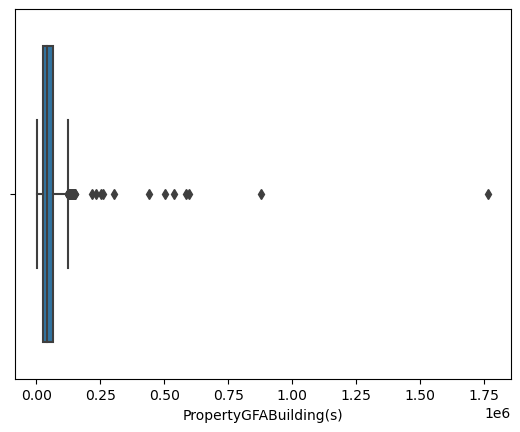

In [95]:
sns.boxplot(df['PropertyGFABuilding(s)']);

In [96]:
#affichage de l'outlier
df.loc[df['PropertyGFABuilding(s)']>1500000,:]

BuildingType PrimaryPropertyType Neighborhood   Latitude   Longitude  \
618  NonResidential            Hospital         EAST  47.608951 -122.322402   

     NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
618                7.0              14           1765970                   0   

     PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
618                 1765970                  1639334.0   

     SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
618                         441551.0                             0.0   

     ENERGYSTARScore  SiteEUIWN(kBtu/sf)  SteamUse(kBtu)  NaturalGas(kBtu)  \
618             54.0               180.5     134943456.0        17316120.0   

     GHGEmissionsIntensity AgeRangeBuilt  
618                   6.97      (20, 30]

In [97]:
#suppression de l'outlier
df.drop(df[df['PropertyGFABuilding(s)']>1500000].index,inplace=True)

In [98]:
#création de nouvelles variables

df['ParkingGFARate'] = df['PropertyGFAParking']/df['PropertyGFATotal']
df['BuildingGFARate'] = df['PropertyGFABuilding(s)']/df['PropertyGFATotal']

#+1 car on compte le rez-de-chaussée
df['GFAPerFloor'] = (df['PropertyGFABuilding(s)']/df['NumberofBuildings'])/(df['NumberofFloors']+1)

In [99]:
df.shape

(1111, 22)

In [100]:
df.head()

BuildingType PrimaryPropertyType Neighborhood  Latitude  Longitude  \
0      NonResidential               Hotel     DOWNTOWN  47.61220 -122.33799   
1      NonResidential               Hotel     DOWNTOWN  47.61317 -122.33393   
3      NonResidential               Hotel     DOWNTOWN  47.61412 -122.33664   
4      NonResidential               Hotel     DOWNTOWN  47.61375 -122.34047   
5  Nonresidential COS               Other     DOWNTOWN  47.61623 -122.33657   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   
1                1.0              11            103566               15064   
3                1.0              10             61320                   0   
4                1.0              18            175580               62000   
5                1.0               2             97288               37198   

   PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
0                   88434                    88434.0   
1                   88502                    83880.0   
3                   61320                    61320.0   
4                  113580                   123445.0   
5                   60090                    88830.0   

   SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
0                              0.0                             0.0   
1                          15064.0                          4622.0   
3                              0.0                             0.0   
4                          68009.0                             0.0   
5                              0.0                             0.0   

   ENERGYSTARScore  SiteEUIWN(kBtu/sf)  SteamUse(kBtu)  NaturalGas(kBtu)  \
0             60.0           84.300003      2003882.00         1276453.0   
1             61.0           97.900002            0.00         5145082.0   
3             56.0          113.300003      2214446.25         1811213.0   
4             75.0          118.699997            0.00         8803998.0   
5              NaN          141.600006            0.00         4715182.0   

   GHGEmissionsIntensity AgeRangeBuilt  ParkingGFARate  BuildingGFARate  \
0                   2.83     (90, 100]        0.000000         1.000000   
1                   2.86      (20, 30]        0.145453         0.854547   
3                   4.67     (90, 100]        0.000000         1.000000   
4                   2.88      (40, 50]        0.353115         0.646885   
5                   3.10      (20, 30]        0.382349         0.617651   

    GFAPerFloor  
0   6802.615385  
1   7375.166667  
3   5574.545455  
4   5977.894737  
5  20030.000000

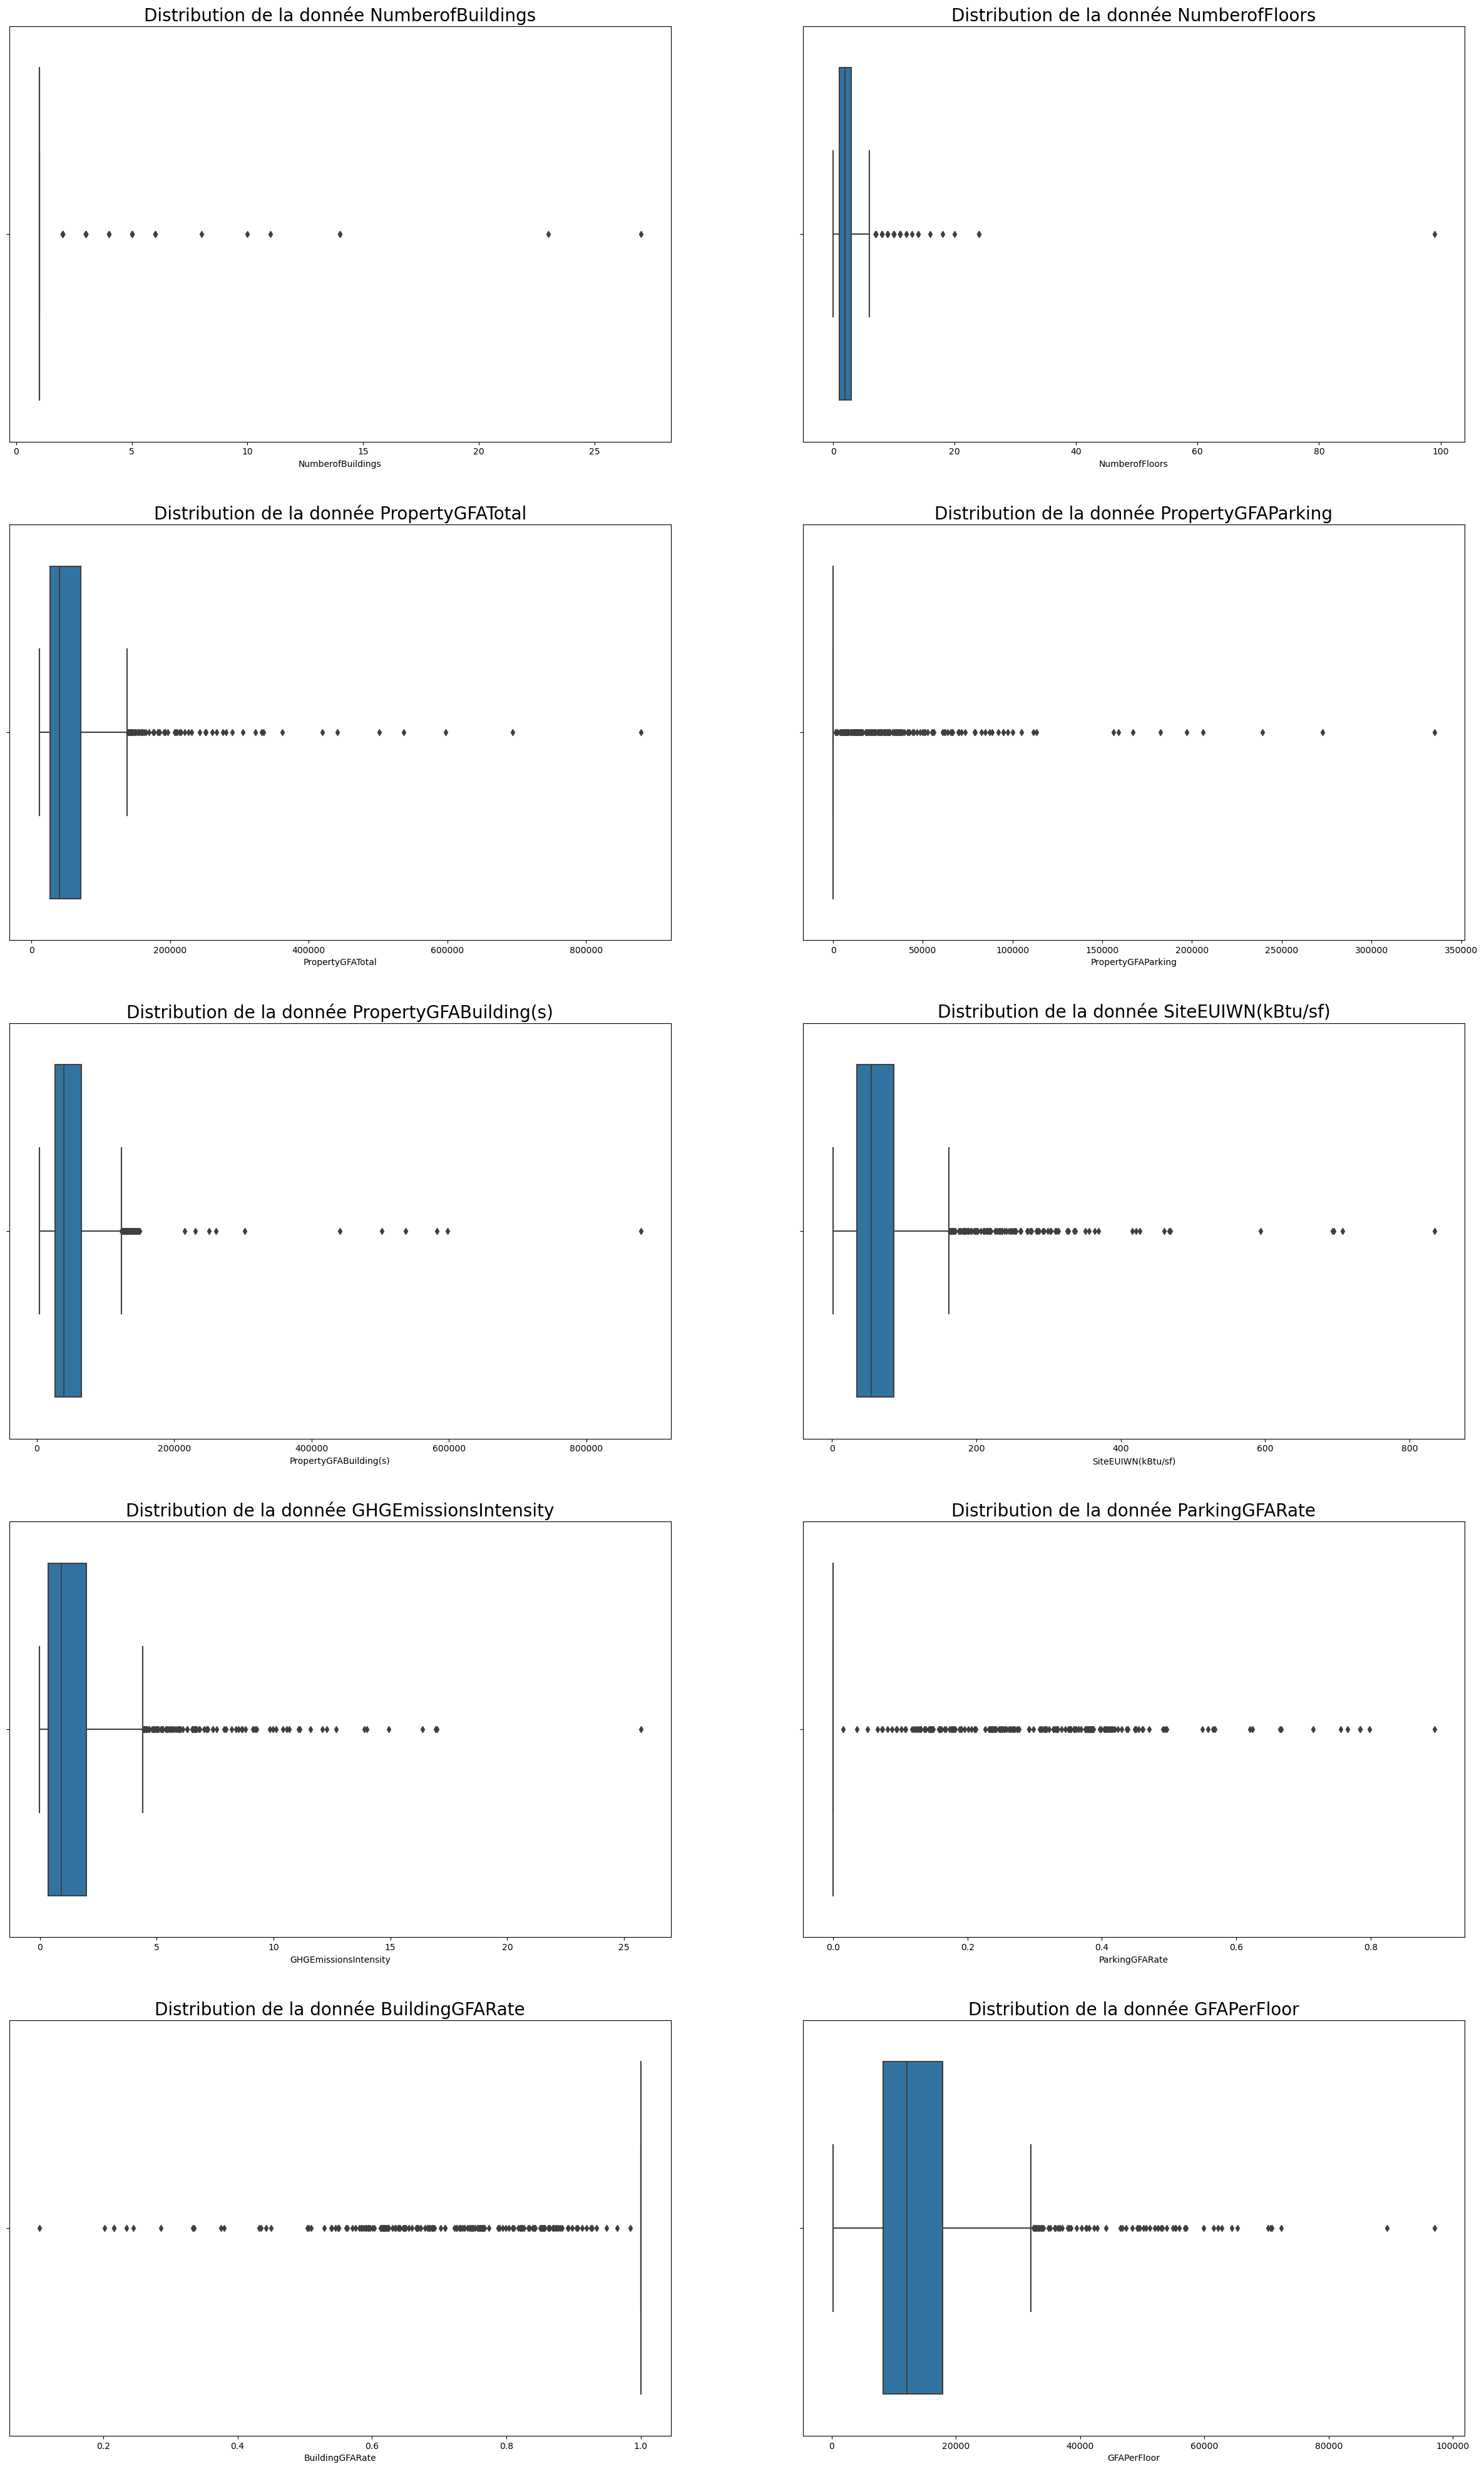

In [101]:
cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'SiteEUIWN(kBtu/sf)', 'GHGEmissionsIntensity','ParkingGFARate',
       'BuildingGFARate','GFAPerFloor']

fig, axes = plt.subplots(5, 2,figsize=(30, 50))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    a = sns.boxplot(df[col],ax=ax)
    a.axes.set_title('Distribution de la donnée '+col,fontsize=20)

plt.show()

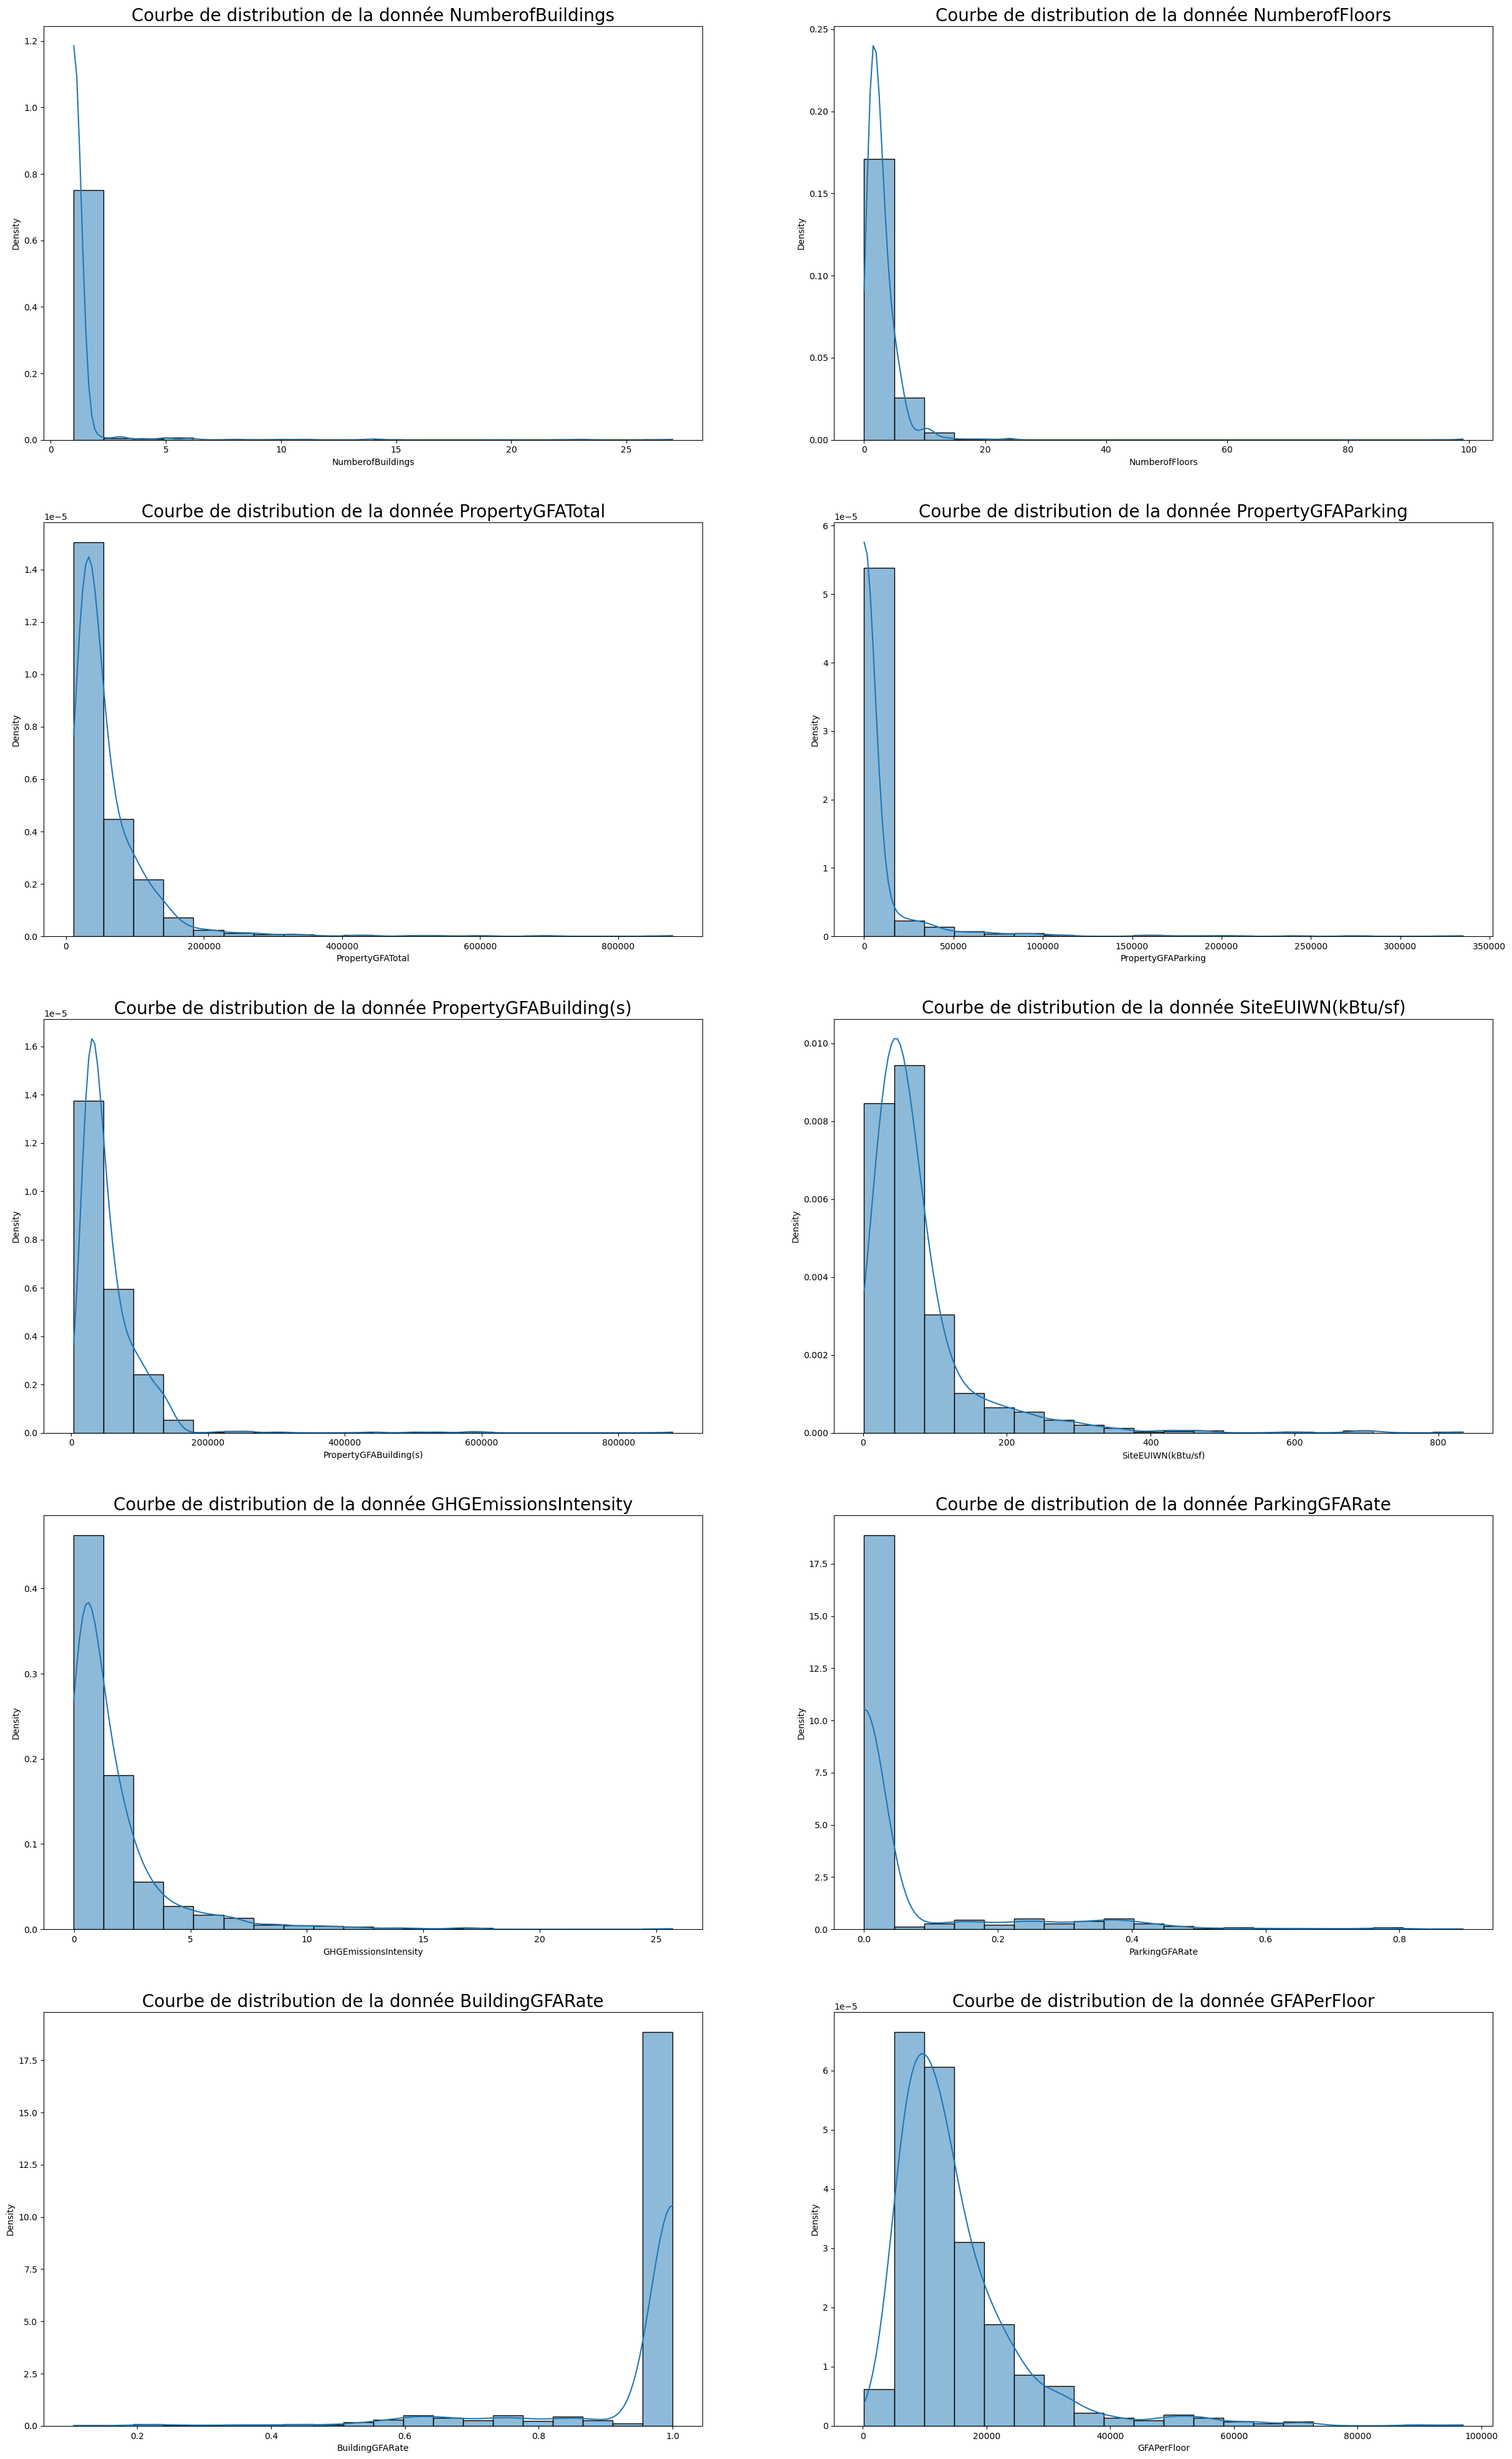

In [102]:

fig, axes = plt.subplots(5, 2,figsize=(30, 50))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    b = sns.histplot(data=df[col], kde=True, stat='density', ax=ax,bins=20)
    b.axes.set_title('Courbe de distribution de la donnée '+col,fontsize=20)

plt.show()

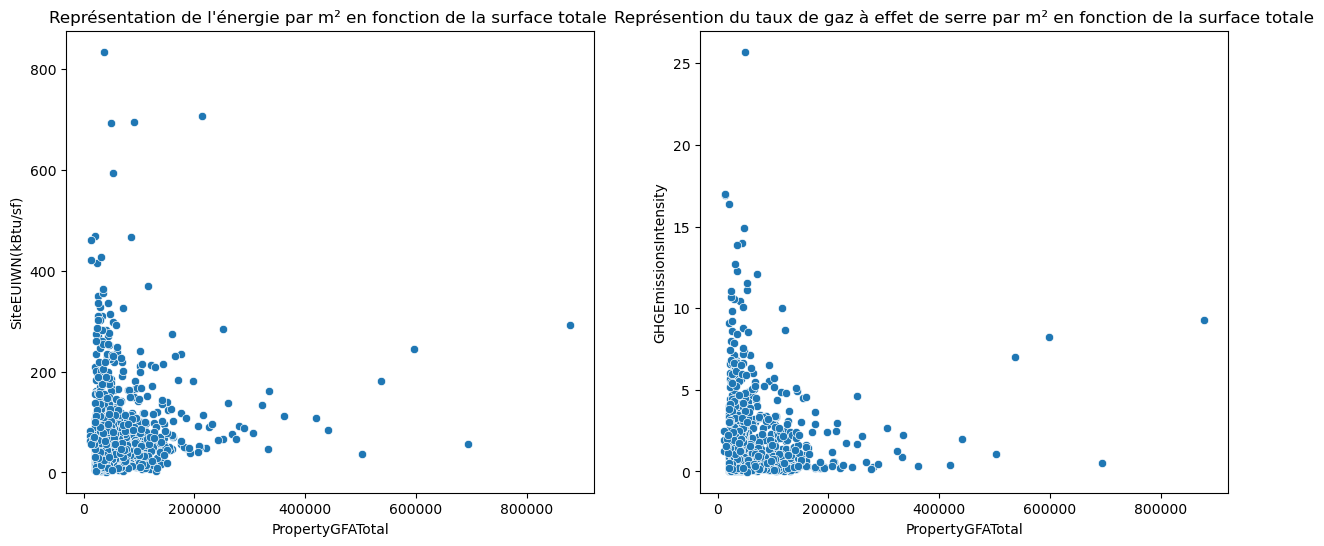

In [103]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.scatterplot(df['PropertyGFATotal'],df['SiteEUIWN(kBtu/sf)'])
plt.title('Représentation de l\'énergie par m² en fonction de la surface totale ')
plt.subplot(1,2,2)
sns.scatterplot(df['PropertyGFATotal'],df['GHGEmissionsIntensity'])
plt.title('Représention du taux de gaz à effet de serre par m² en fonction de la surface totale')
plt.show()

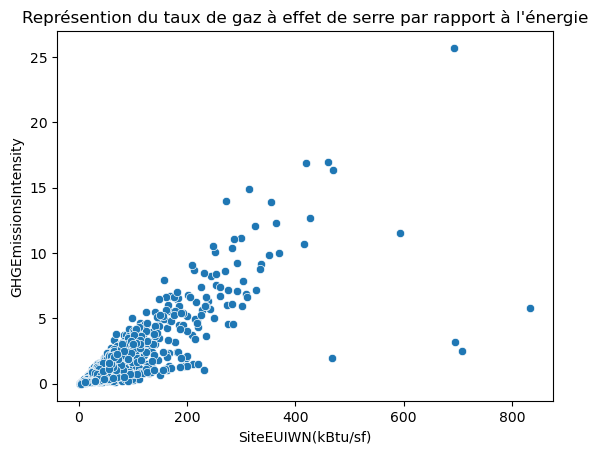

In [104]:
sns.scatterplot(df['SiteEUIWN(kBtu/sf)'],df['GHGEmissionsIntensity']);
plt.title('Représention du taux de gaz à effet de serre par rapport à l\'énergie');

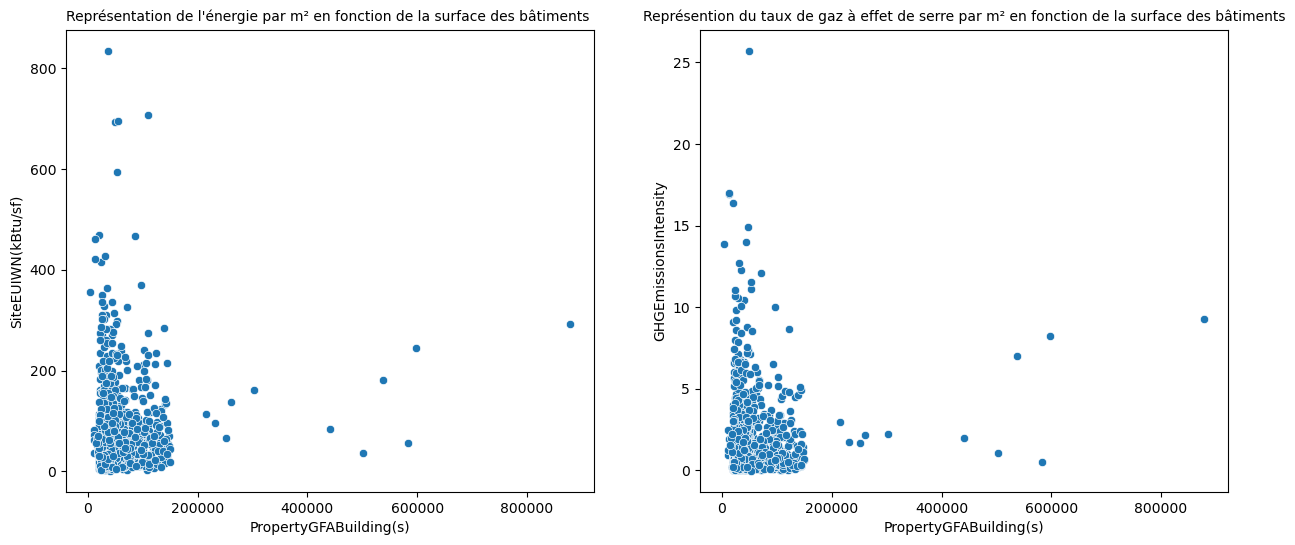

In [105]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.scatterplot(df['PropertyGFABuilding(s)'],df['SiteEUIWN(kBtu/sf)'])
plt.title('Représentation de l\'énergie par m² en fonction de la surface des bâtiments ',fontsize=10)
plt.subplot(1,2,2)
sns.scatterplot(df['PropertyGFABuilding(s)'],df['GHGEmissionsIntensity'])
plt.title('Représention du taux de gaz à effet de serre par m² en fonction de la surface des bâtiments',fontsize=10)
plt.show()

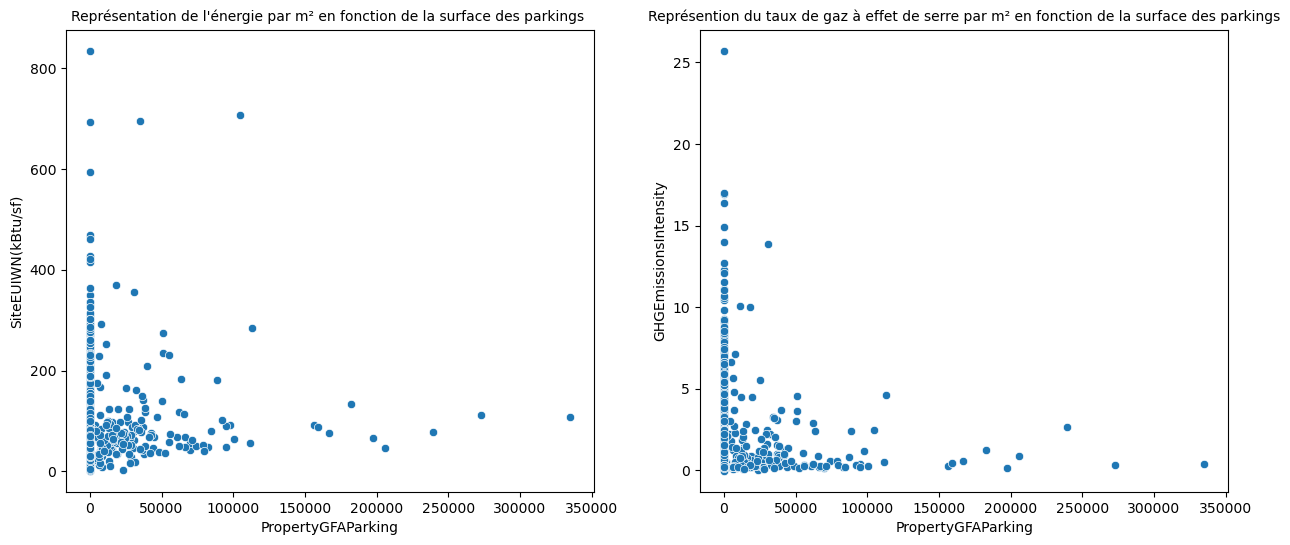

In [106]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.scatterplot(df['PropertyGFAParking'],df['SiteEUIWN(kBtu/sf)'])
plt.title('Représentation de l\'énergie par m² en fonction de la surface des parkings ',fontsize=10)
plt.subplot(1,2,2)
sns.scatterplot(df['PropertyGFAParking'],df['GHGEmissionsIntensity'])
plt.title('Représention du taux de gaz à effet de serre par m² en fonction de la surface des parkings',fontsize=10)
plt.show()

In [107]:
df.head()

BuildingType PrimaryPropertyType Neighborhood  Latitude  Longitude  \
0      NonResidential               Hotel     DOWNTOWN  47.61220 -122.33799   
1      NonResidential               Hotel     DOWNTOWN  47.61317 -122.33393   
3      NonResidential               Hotel     DOWNTOWN  47.61412 -122.33664   
4      NonResidential               Hotel     DOWNTOWN  47.61375 -122.34047   
5  Nonresidential COS               Other     DOWNTOWN  47.61623 -122.33657   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   
1                1.0              11            103566               15064   
3                1.0              10             61320                   0   
4                1.0              18            175580               62000   
5                1.0               2             97288               37198   

   PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
0                   88434                    88434.0   
1                   88502                    83880.0   
3                   61320                    61320.0   
4                  113580                   123445.0   
5                   60090                    88830.0   

   SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
0                              0.0                             0.0   
1                          15064.0                          4622.0   
3                              0.0                             0.0   
4                          68009.0                             0.0   
5                              0.0                             0.0   

   ENERGYSTARScore  SiteEUIWN(kBtu/sf)  SteamUse(kBtu)  NaturalGas(kBtu)  \
0             60.0           84.300003      2003882.00         1276453.0   
1             61.0           97.900002            0.00         5145082.0   
3             56.0          113.300003      2214446.25         1811213.0   
4             75.0          118.699997            0.00         8803998.0   
5              NaN          141.600006            0.00         4715182.0   

   GHGEmissionsIntensity AgeRangeBuilt  ParkingGFARate  BuildingGFARate  \
0                   2.83     (90, 100]        0.000000         1.000000   
1                   2.86      (20, 30]        0.145453         0.854547   
3                   4.67     (90, 100]        0.000000         1.000000   
4                   2.88      (40, 50]        0.353115         0.646885   
5                   3.10      (20, 30]        0.382349         0.617651   

    GFAPerFloor  
0   6802.615385  
1   7375.166667  
3   5574.545455  
4   5977.894737  
5  20030.000000

In [108]:
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

[]

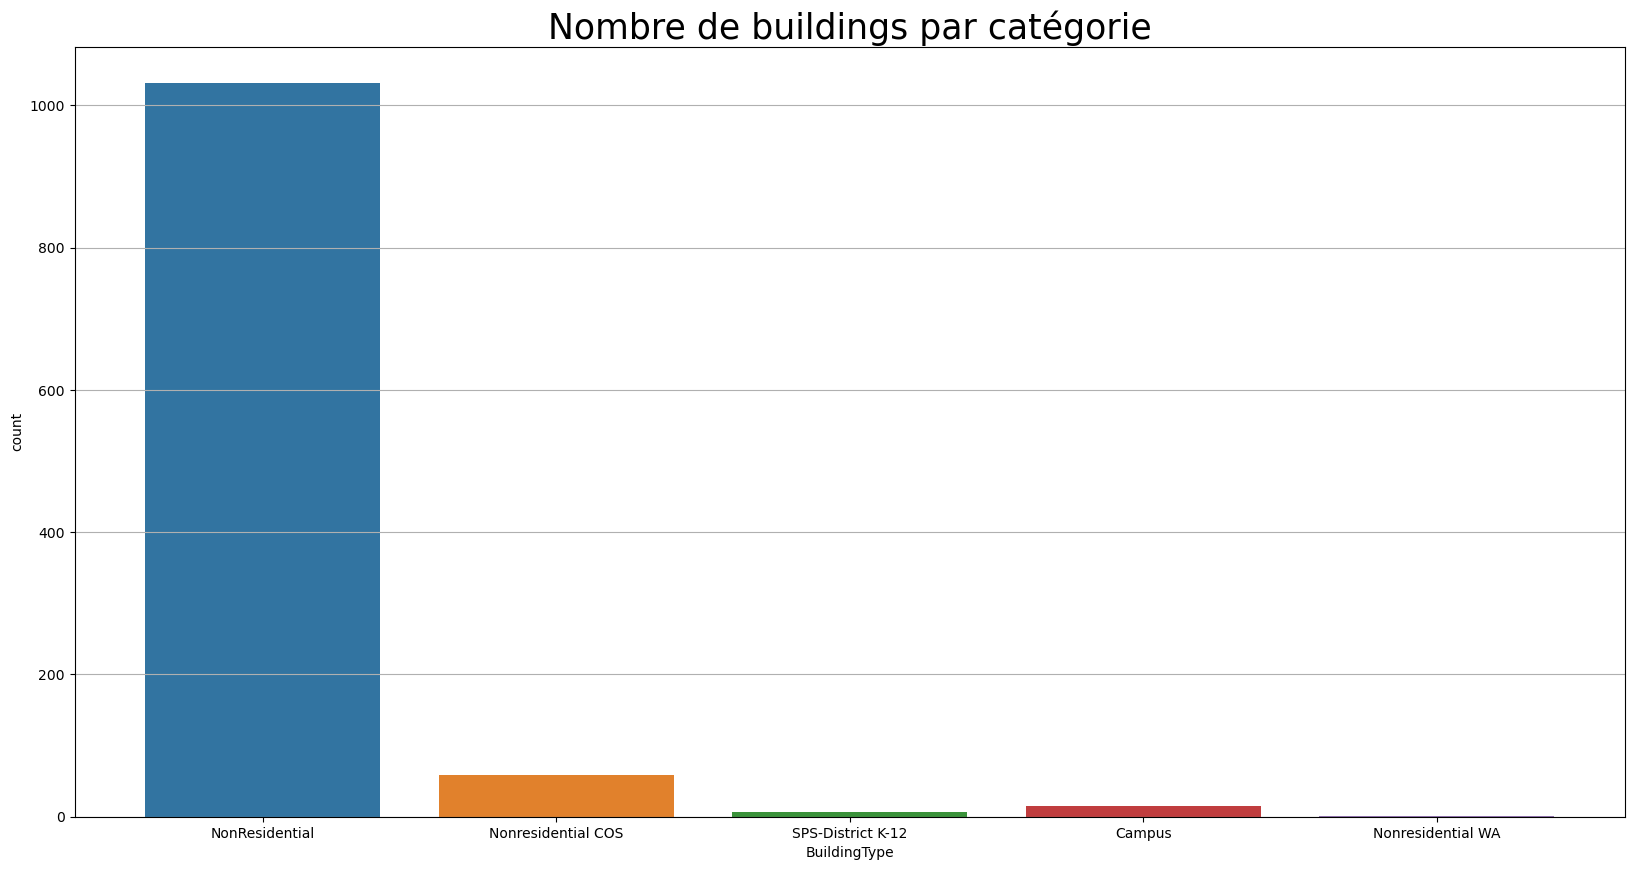

In [109]:
plt.figure(figsize=[20,10])
plt.title('Nombre de buildings par catégorie',fontsize=25)
ax=sns.countplot(df['BuildingType'])
plt.grid(axis='y')
plt.plot()

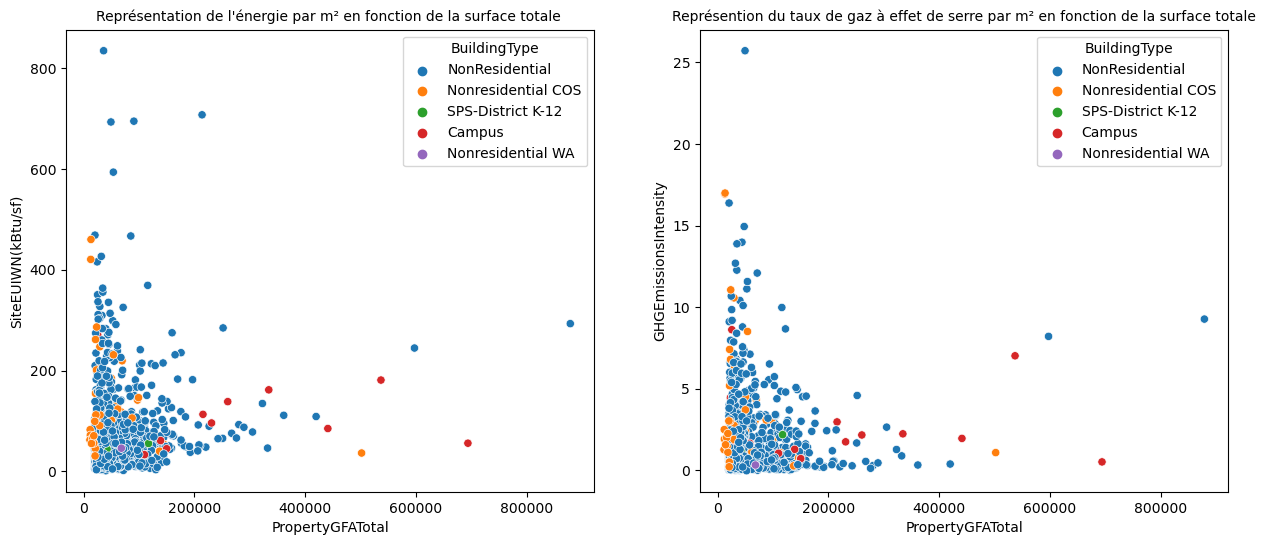

In [110]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.scatterplot(df['PropertyGFATotal'],df['SiteEUIWN(kBtu/sf)'],hue=df['BuildingType'])
plt.title('Représentation de l\'énergie par m² en fonction de la surface totale ',fontsize=10)
plt.subplot(1,2,2)
sns.scatterplot(df['PropertyGFATotal'],df['GHGEmissionsIntensity'],hue=df['BuildingType'])
plt.title('Représention du taux de gaz à effet de serre par m² en fonction de la surface totale',fontsize=10)
plt.show()

In [111]:
df['Neighborhood'].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'MAGNOLIA / QUEEN ANNE',
       'BALLARD', 'GREATER DUWAMISH', 'LAKE UNION', 'CENTRAL',
       'NORTHWEST', 'SOUTHEAST', 'DELRIDGE', 'NORTH', 'SOUTHWEST',
       'North', 'Delridge', 'Ballard', 'Northwest', 'Central',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

[]

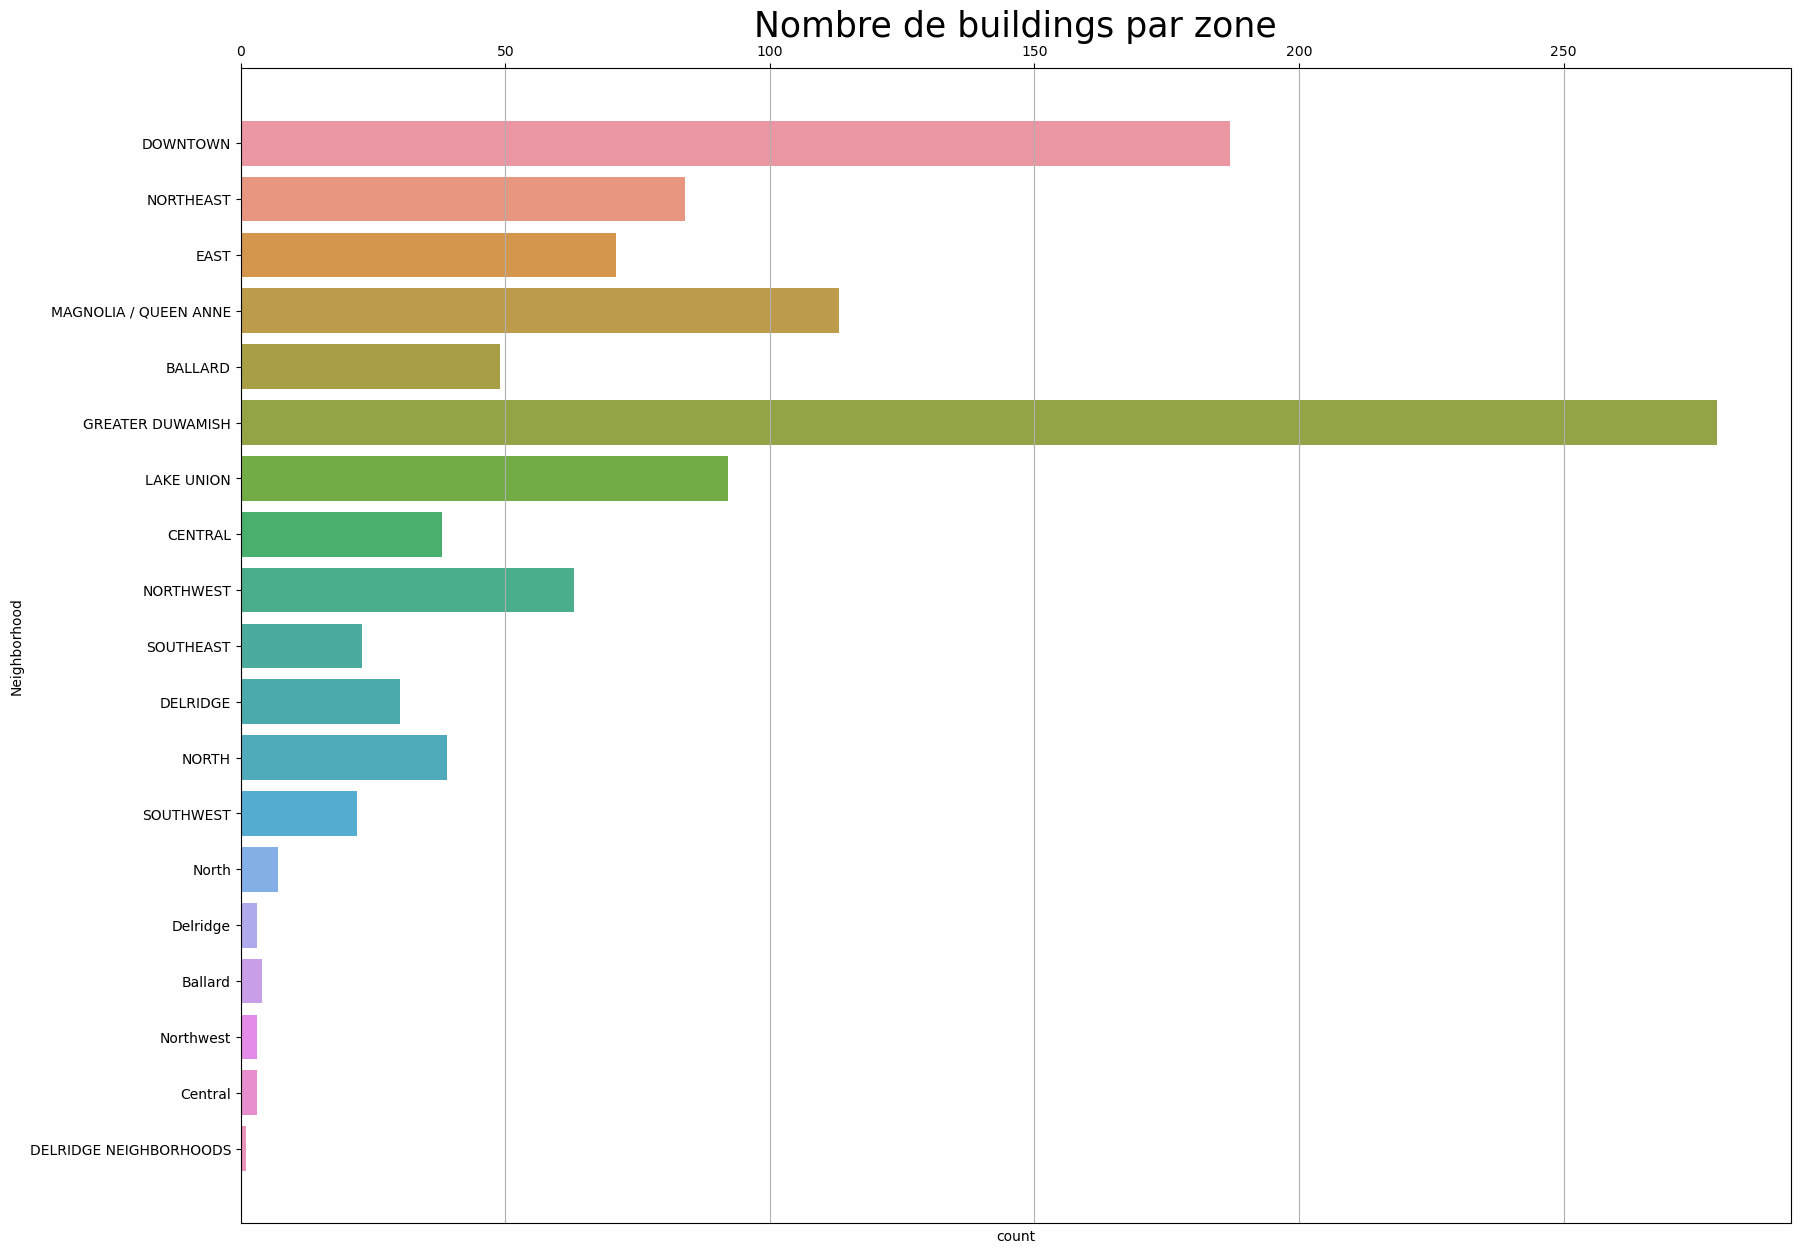

In [112]:
plt.figure(figsize=[20,15])
plt.title('Nombre de buildings par zone',fontsize=25)
ax=sns.countplot(y=df['Neighborhood'])
plt.grid(axis='x')
ax.xaxis.set_ticks_position('top')
plt.plot()

In [113]:
df.loc[df['Neighborhood']=='DELRIDGE NEIGHBORHOODS','Neighborhood'] = 'DELRIDGE'

[]

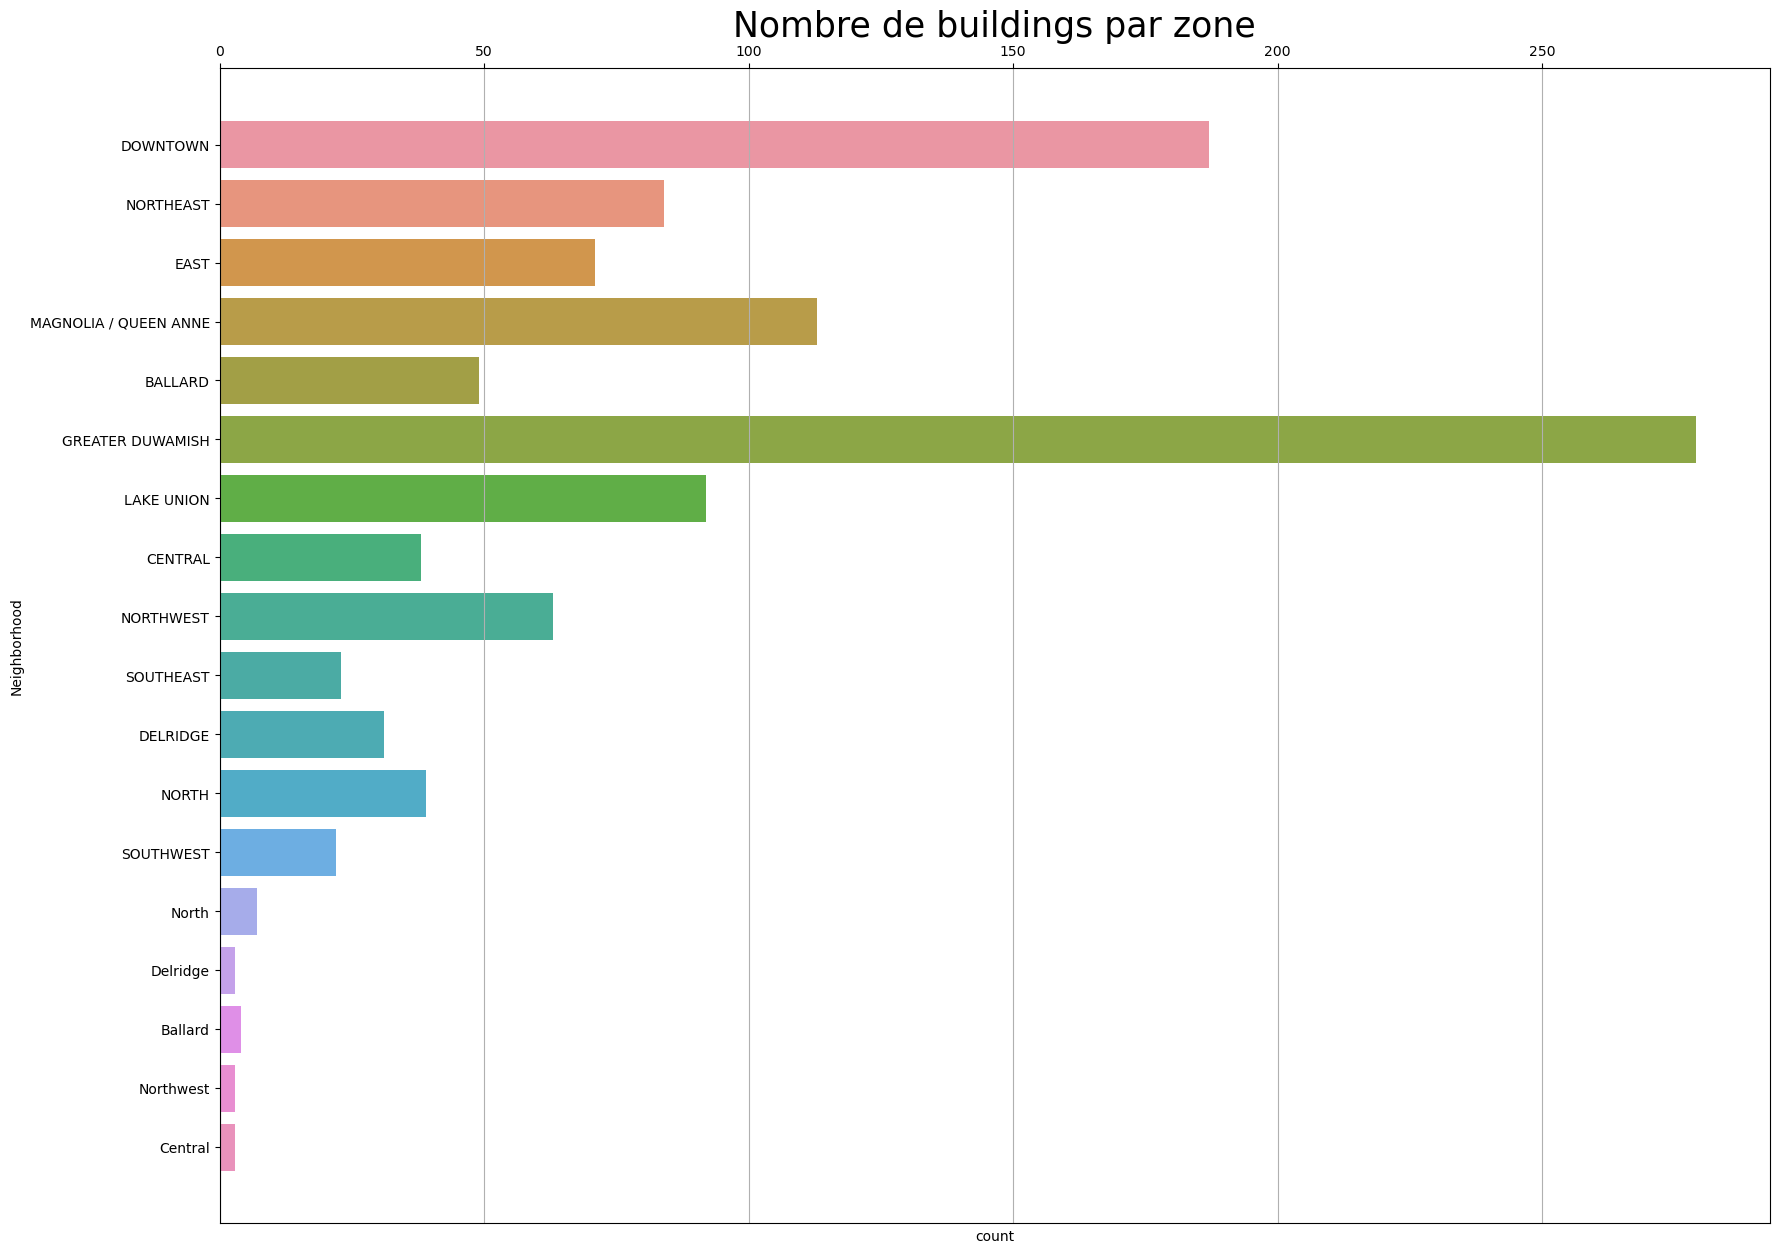

In [114]:
plt.figure(figsize=[20,15])
plt.title('Nombre de buildings par zone',fontsize=25)
ax=sns.countplot(y=df['Neighborhood'])
plt.grid(axis='x')
ax.xaxis.set_ticks_position('top')
plt.plot()

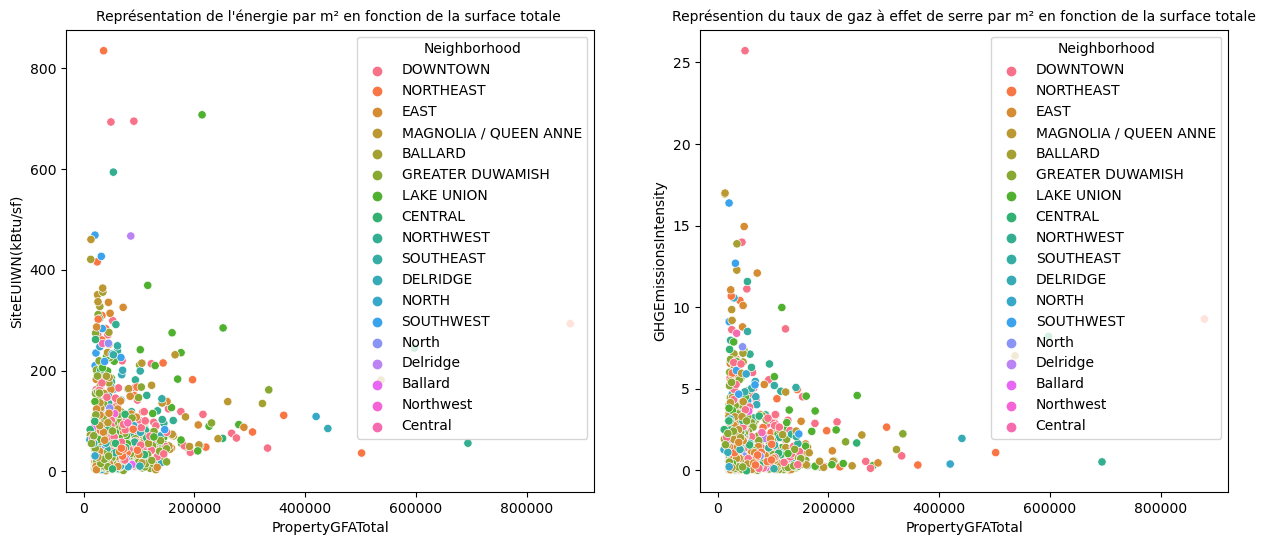

In [115]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.scatterplot(df['PropertyGFATotal'],df['SiteEUIWN(kBtu/sf)'],hue=df['Neighborhood'])
plt.title('Représentation de l\'énergie par m² en fonction de la surface totale ',fontsize=10)
plt.subplot(1,2,2)
sns.scatterplot(df['PropertyGFATotal'],df['GHGEmissionsIntensity'],hue=df['Neighborhood'])
plt.title('Représention du taux de gaz à effet de serre par m² en fonction de la surface totale',fontsize=10)
plt.show()

In [116]:
df['Neighborhood'].unique()

array(['DOWNTOWN', 'NORTHEAST', 'EAST', 'MAGNOLIA / QUEEN ANNE',
       'BALLARD', 'GREATER DUWAMISH', 'LAKE UNION', 'CENTRAL',
       'NORTHWEST', 'SOUTHEAST', 'DELRIDGE', 'NORTH', 'SOUTHWEST',
       'North', 'Delridge', 'Ballard', 'Northwest', 'Central'],
      dtype=object)

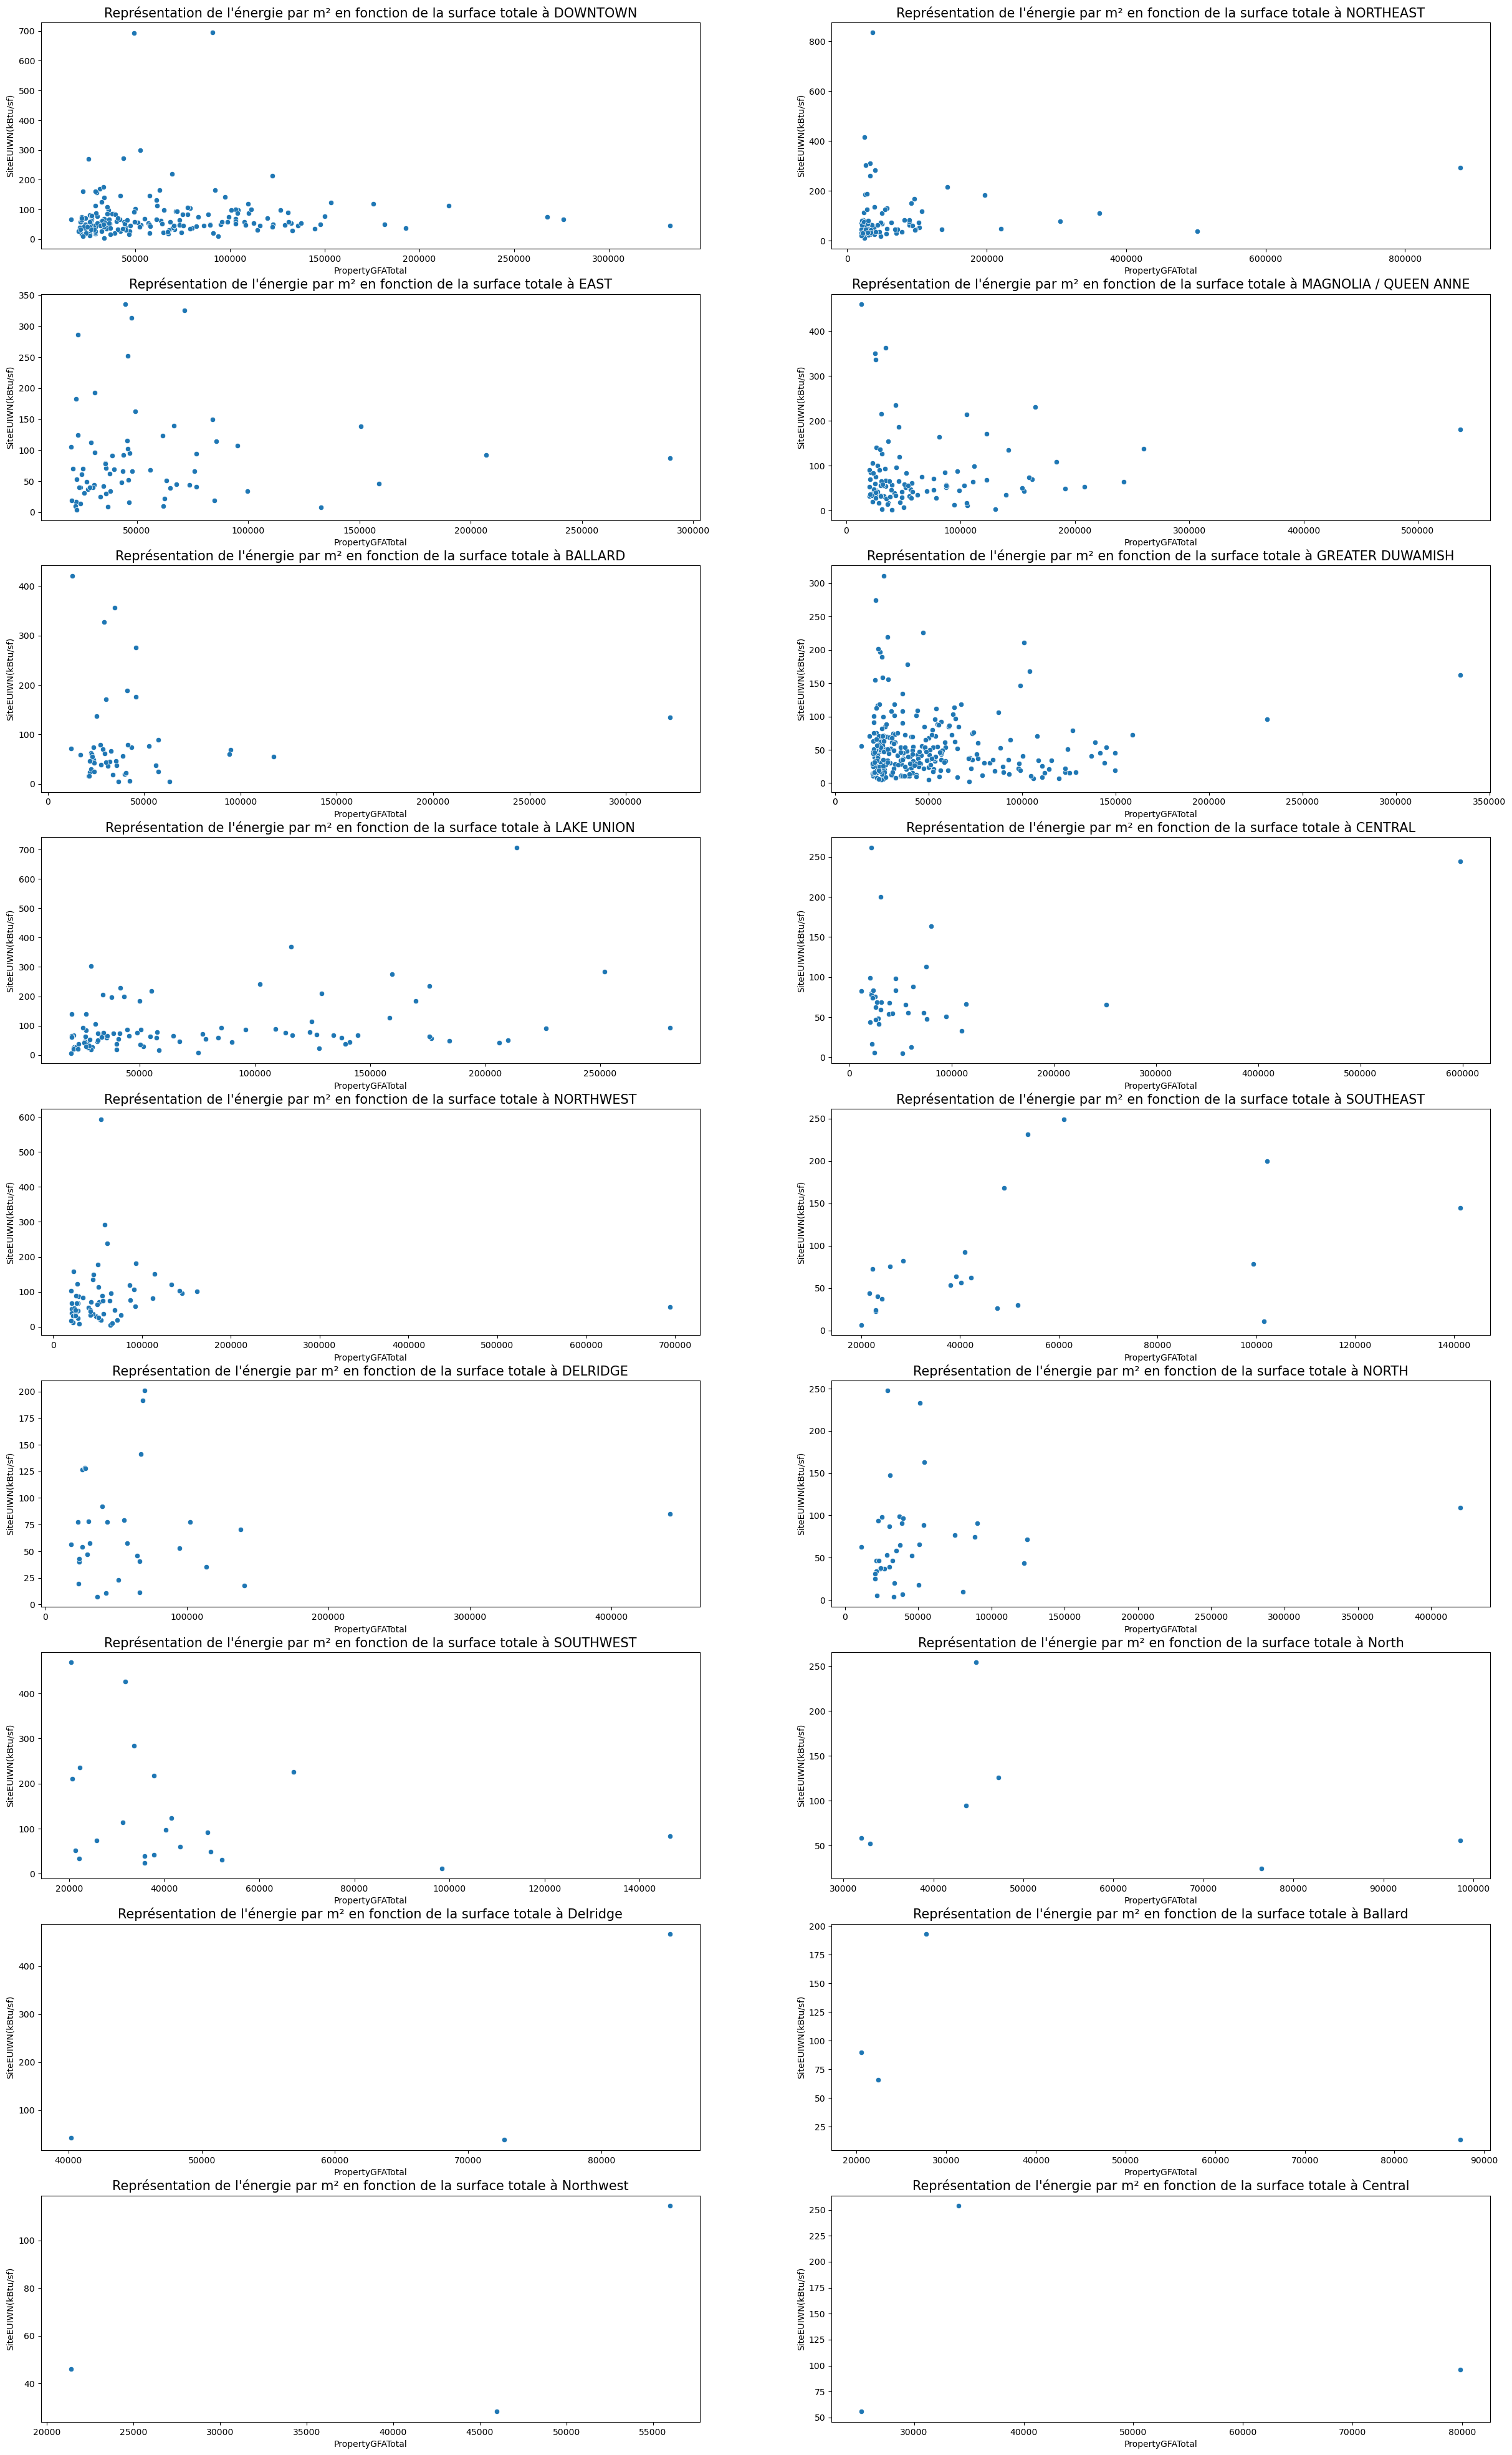

In [117]:
neighbors = ['DOWNTOWN', 'NORTHEAST', 'EAST', 'MAGNOLIA / QUEEN ANNE',
       'BALLARD', 'GREATER DUWAMISH', 'LAKE UNION', 'CENTRAL',
       'NORTHWEST', 'SOUTHEAST', 'DELRIDGE', 'NORTH', 'SOUTHWEST',
       'North', 'Delridge', 'Ballard', 'Northwest', 'Central']

fig, axes = plt.subplots(9, 2,figsize=(30, 50))
axes = axes.ravel()

for neighbor, ax in zip(neighbors, axes):
    a = sns.scatterplot(df.loc[df['Neighborhood']==str(neighbor),'PropertyGFATotal'],df.loc[df['Neighborhood']==str(neighbor),'SiteEUIWN(kBtu/sf)'],ax=ax)
    a.axes.set_title('Représentation de l\'énergie par m² en fonction de la surface totale à '+neighbor,fontsize=15)

plt.show()

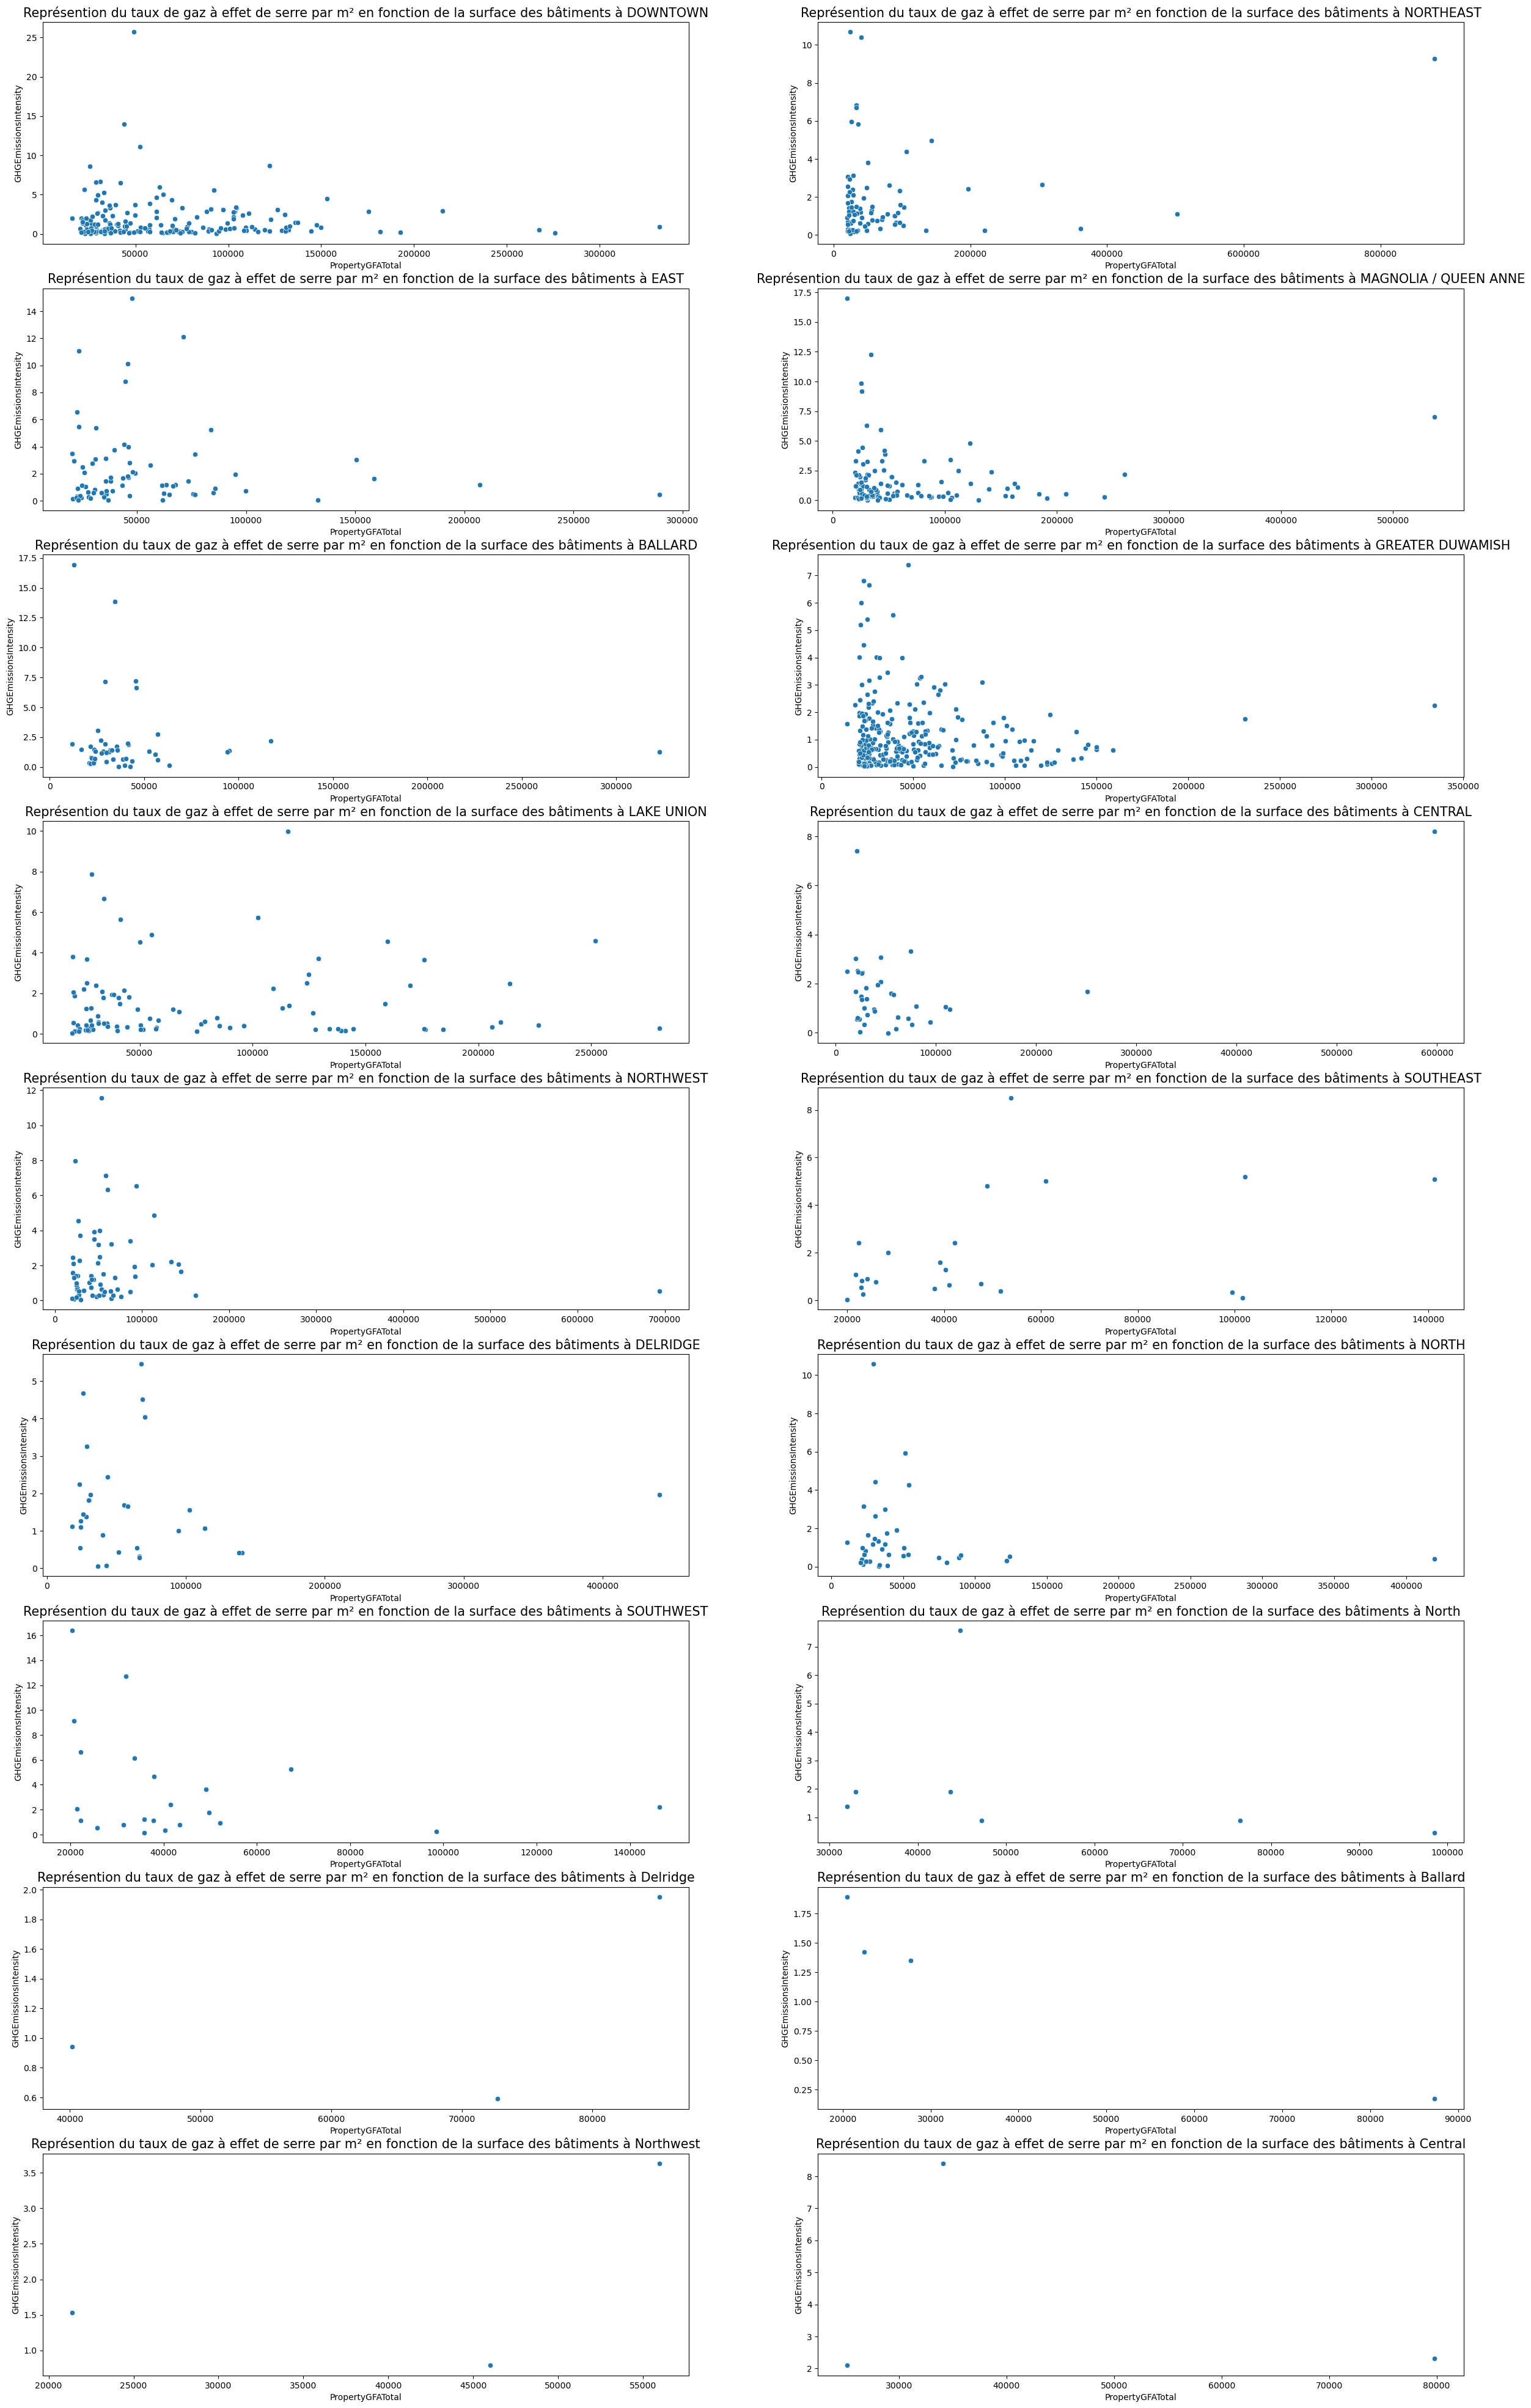

In [118]:
fig, axes = plt.subplots(9, 2,figsize=(30, 50))
axes = axes.ravel()

for neighbor, ax in zip(neighbors, axes):
    a = sns.scatterplot(df.loc[df['Neighborhood']==str(neighbor),'PropertyGFATotal'],df.loc[df['Neighborhood']==str(neighbor),'GHGEmissionsIntensity'],ax=ax)
    a.axes.set_title('Représention du taux de gaz à effet de serre par m² en fonction de la surface des bâtiments à '+neighbor,fontsize=15)

plt.show()

[]

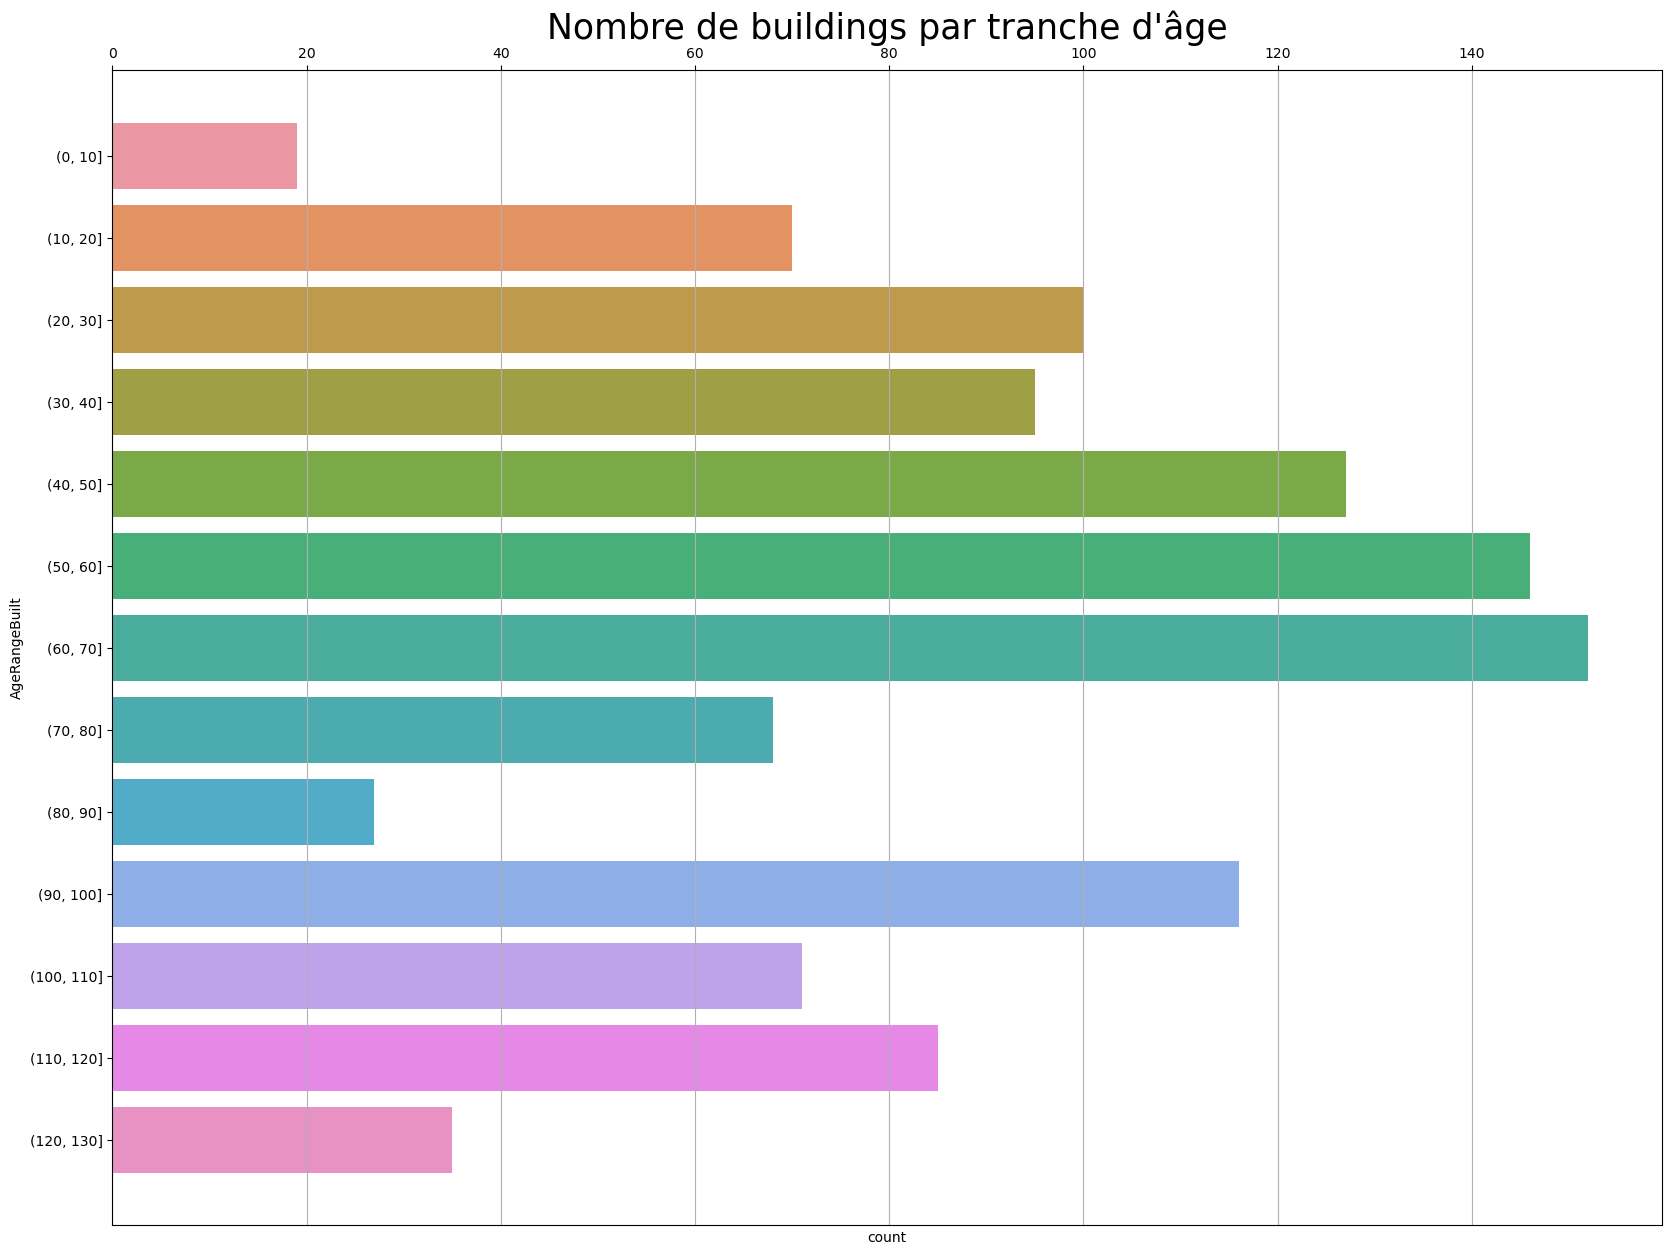

In [119]:
plt.figure(figsize=[20,15])
plt.title('Nombre de buildings par tranche d\'âge',fontsize=25)
ax=sns.countplot(y=df['AgeRangeBuilt'])
plt.grid(axis='x')
ax.xaxis.set_ticks_position('top')
plt.plot()

In [120]:
df['AgeRangeBuilt'] = df['AgeRangeBuilt'].astype('str')

In [121]:
df.dtypes

BuildingType                        object
PrimaryPropertyType                 object
Neighborhood                        object
Latitude                           float64
Longitude                          float64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseTypeGFA    float64
ThirdLargestPropertyUseTypeGFA     float64
ENERGYSTARScore                    float64
SiteEUIWN(kBtu/sf)                 float64
SteamUse(kBtu)                     float64
NaturalGas(kBtu)                   float64
GHGEmissionsIntensity              float64
AgeRangeBuilt                       object
ParkingGFARate                     float64
BuildingGFARate                    float64
GFAPerFloor                        float64
dtype: object

In [122]:
df['AgeRangeBuilt'].unique()

array(['(90, 100]', '(20, 30]', '(40, 50]', '(50, 60]', '(100, 110]',
       '(30, 40]', '(60, 70]', '(120, 130]', '(110, 120]', '(10, 20]',
       '(80, 90]', '(70, 80]', '(0, 10]'], dtype=object)

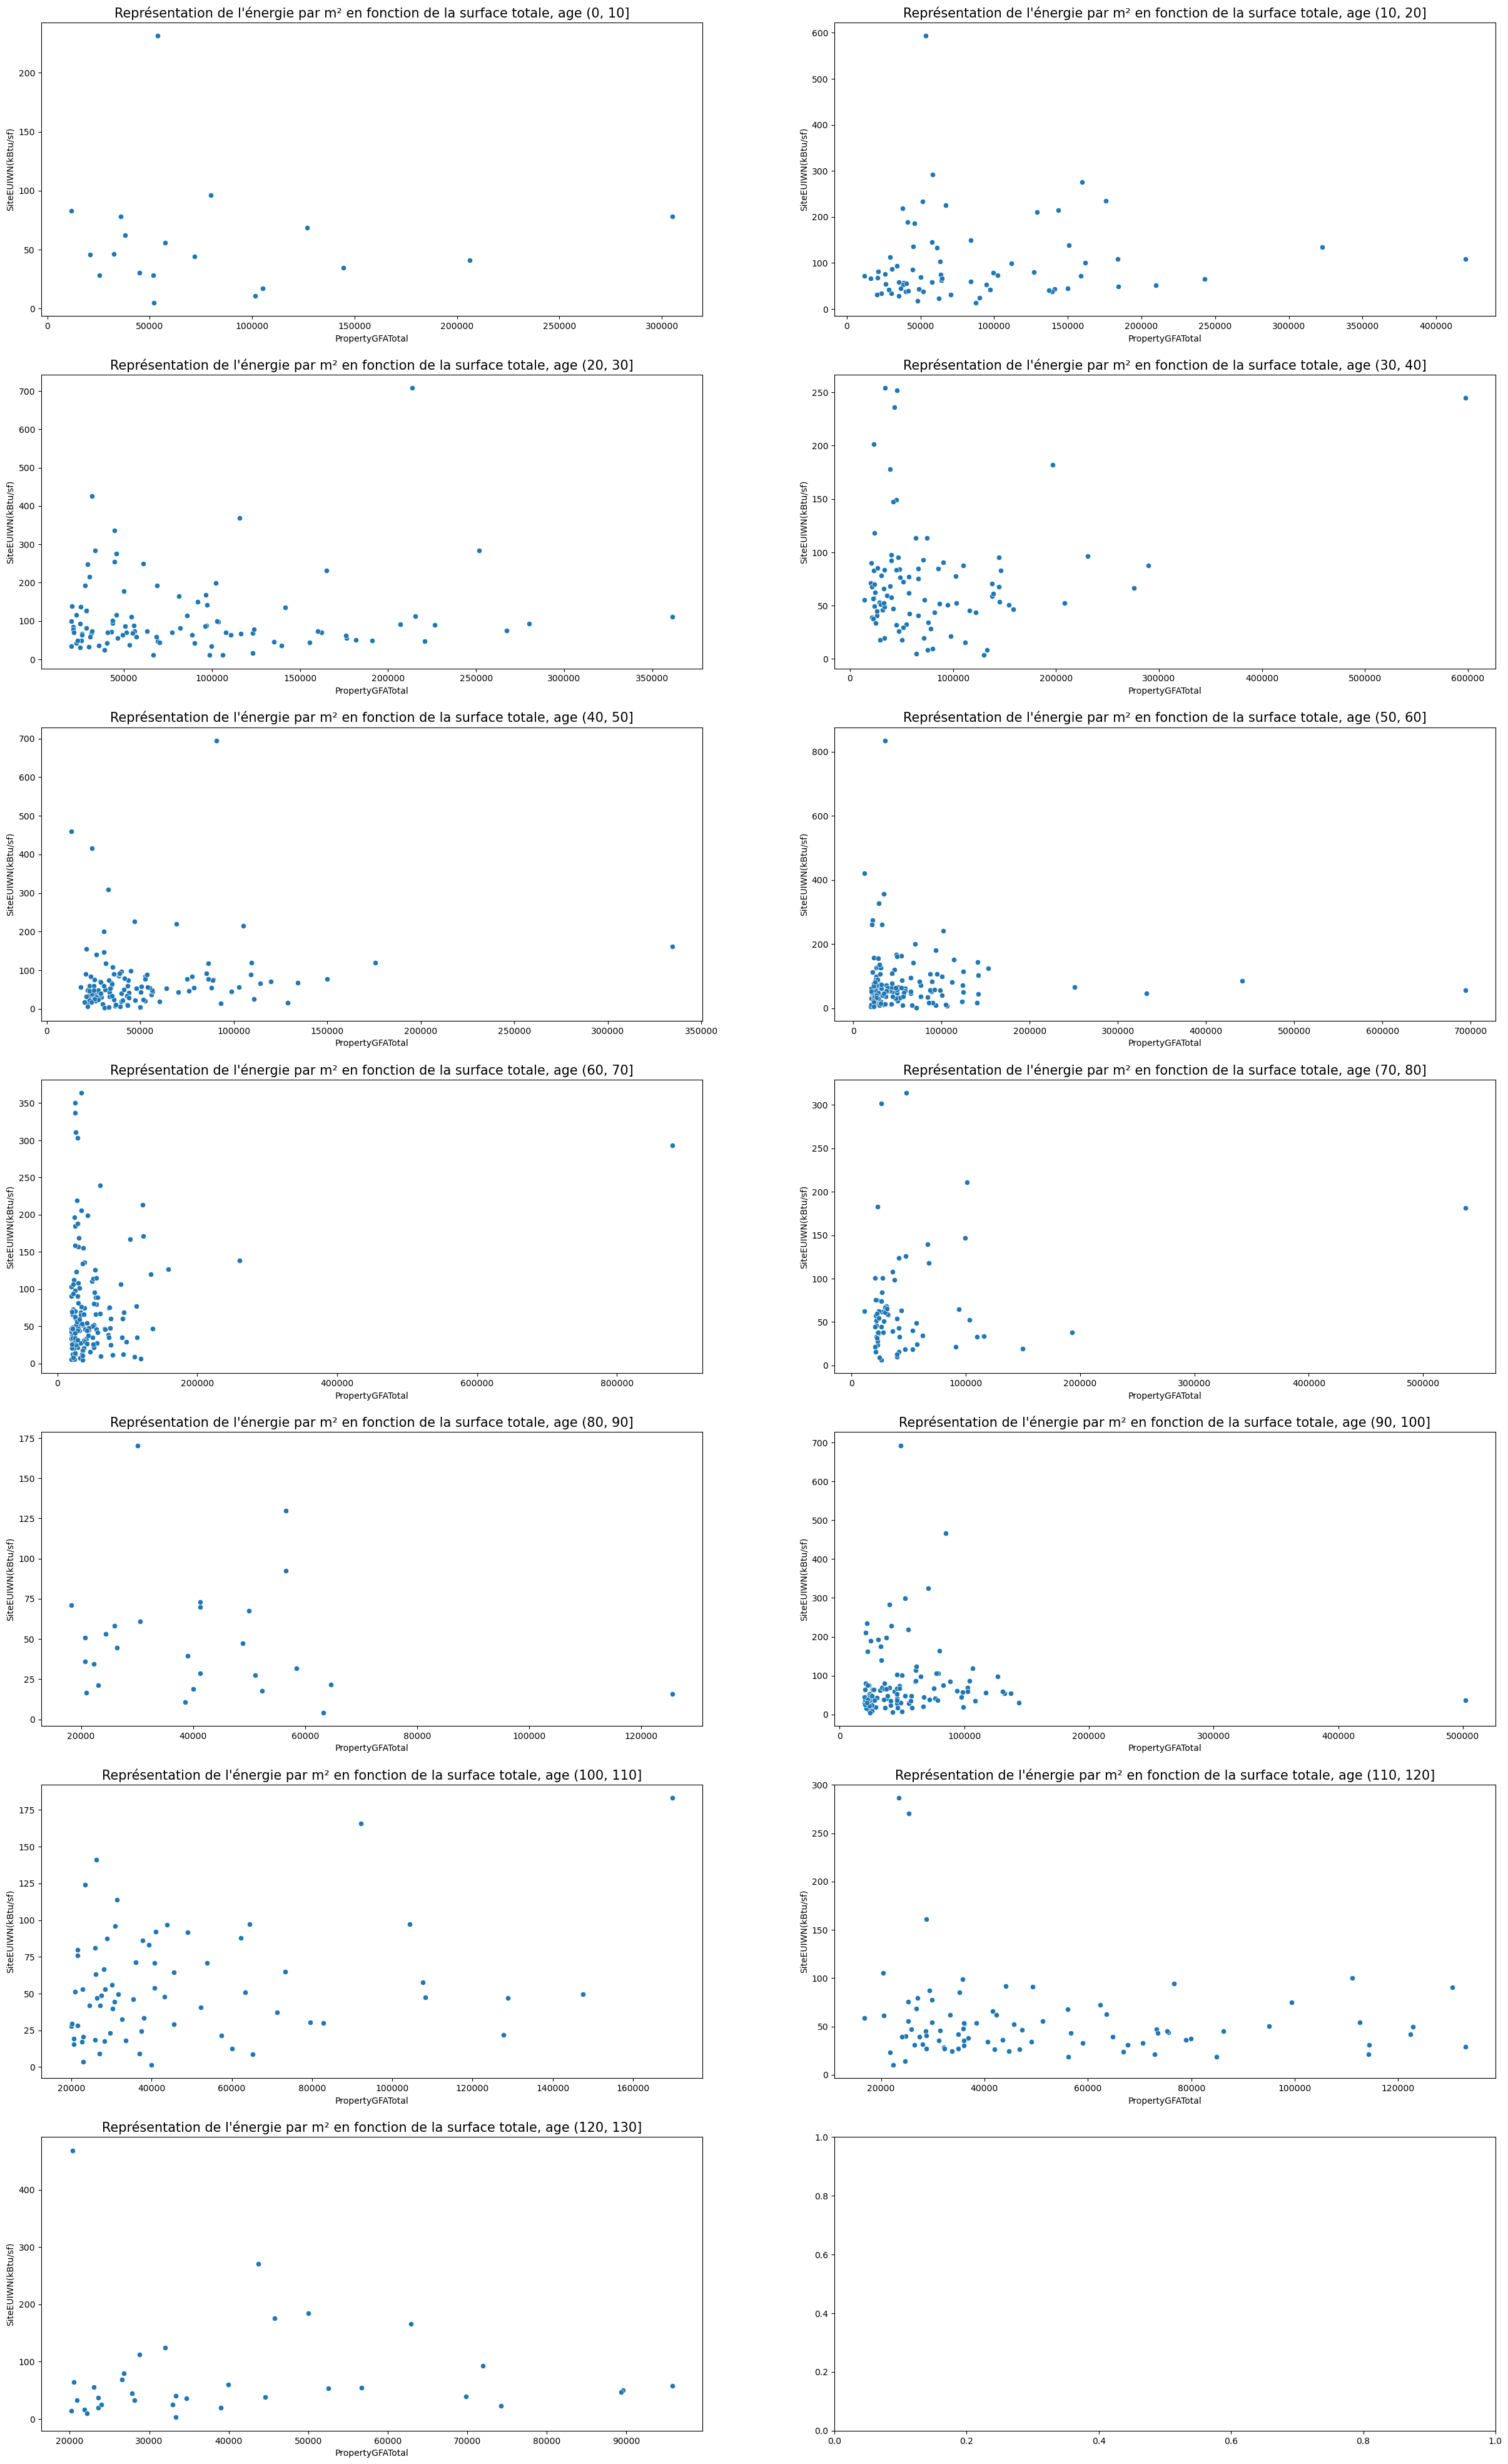

In [123]:
ages = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]',
       '(40, 50]', '(50, 60]', '(60, 70]', '(70, 80]',
       '(80, 90]', '(90, 100]', '(100, 110]', '(110, 120]', '(120, 130]']

fig, axes = plt.subplots(7, 2,figsize=(30, 50))
axes = axes.ravel()

for age, ax in zip(ages, axes):
    a = sns.scatterplot(df.loc[df['AgeRangeBuilt']==str(age),'PropertyGFATotal'],df.loc[df['AgeRangeBuilt']==str(age),'SiteEUIWN(kBtu/sf)'],ax=ax)
    a.axes.set_title('Représentation de l\'énergie par m² en fonction de la surface totale, age '+age,fontsize=15)

plt.show()

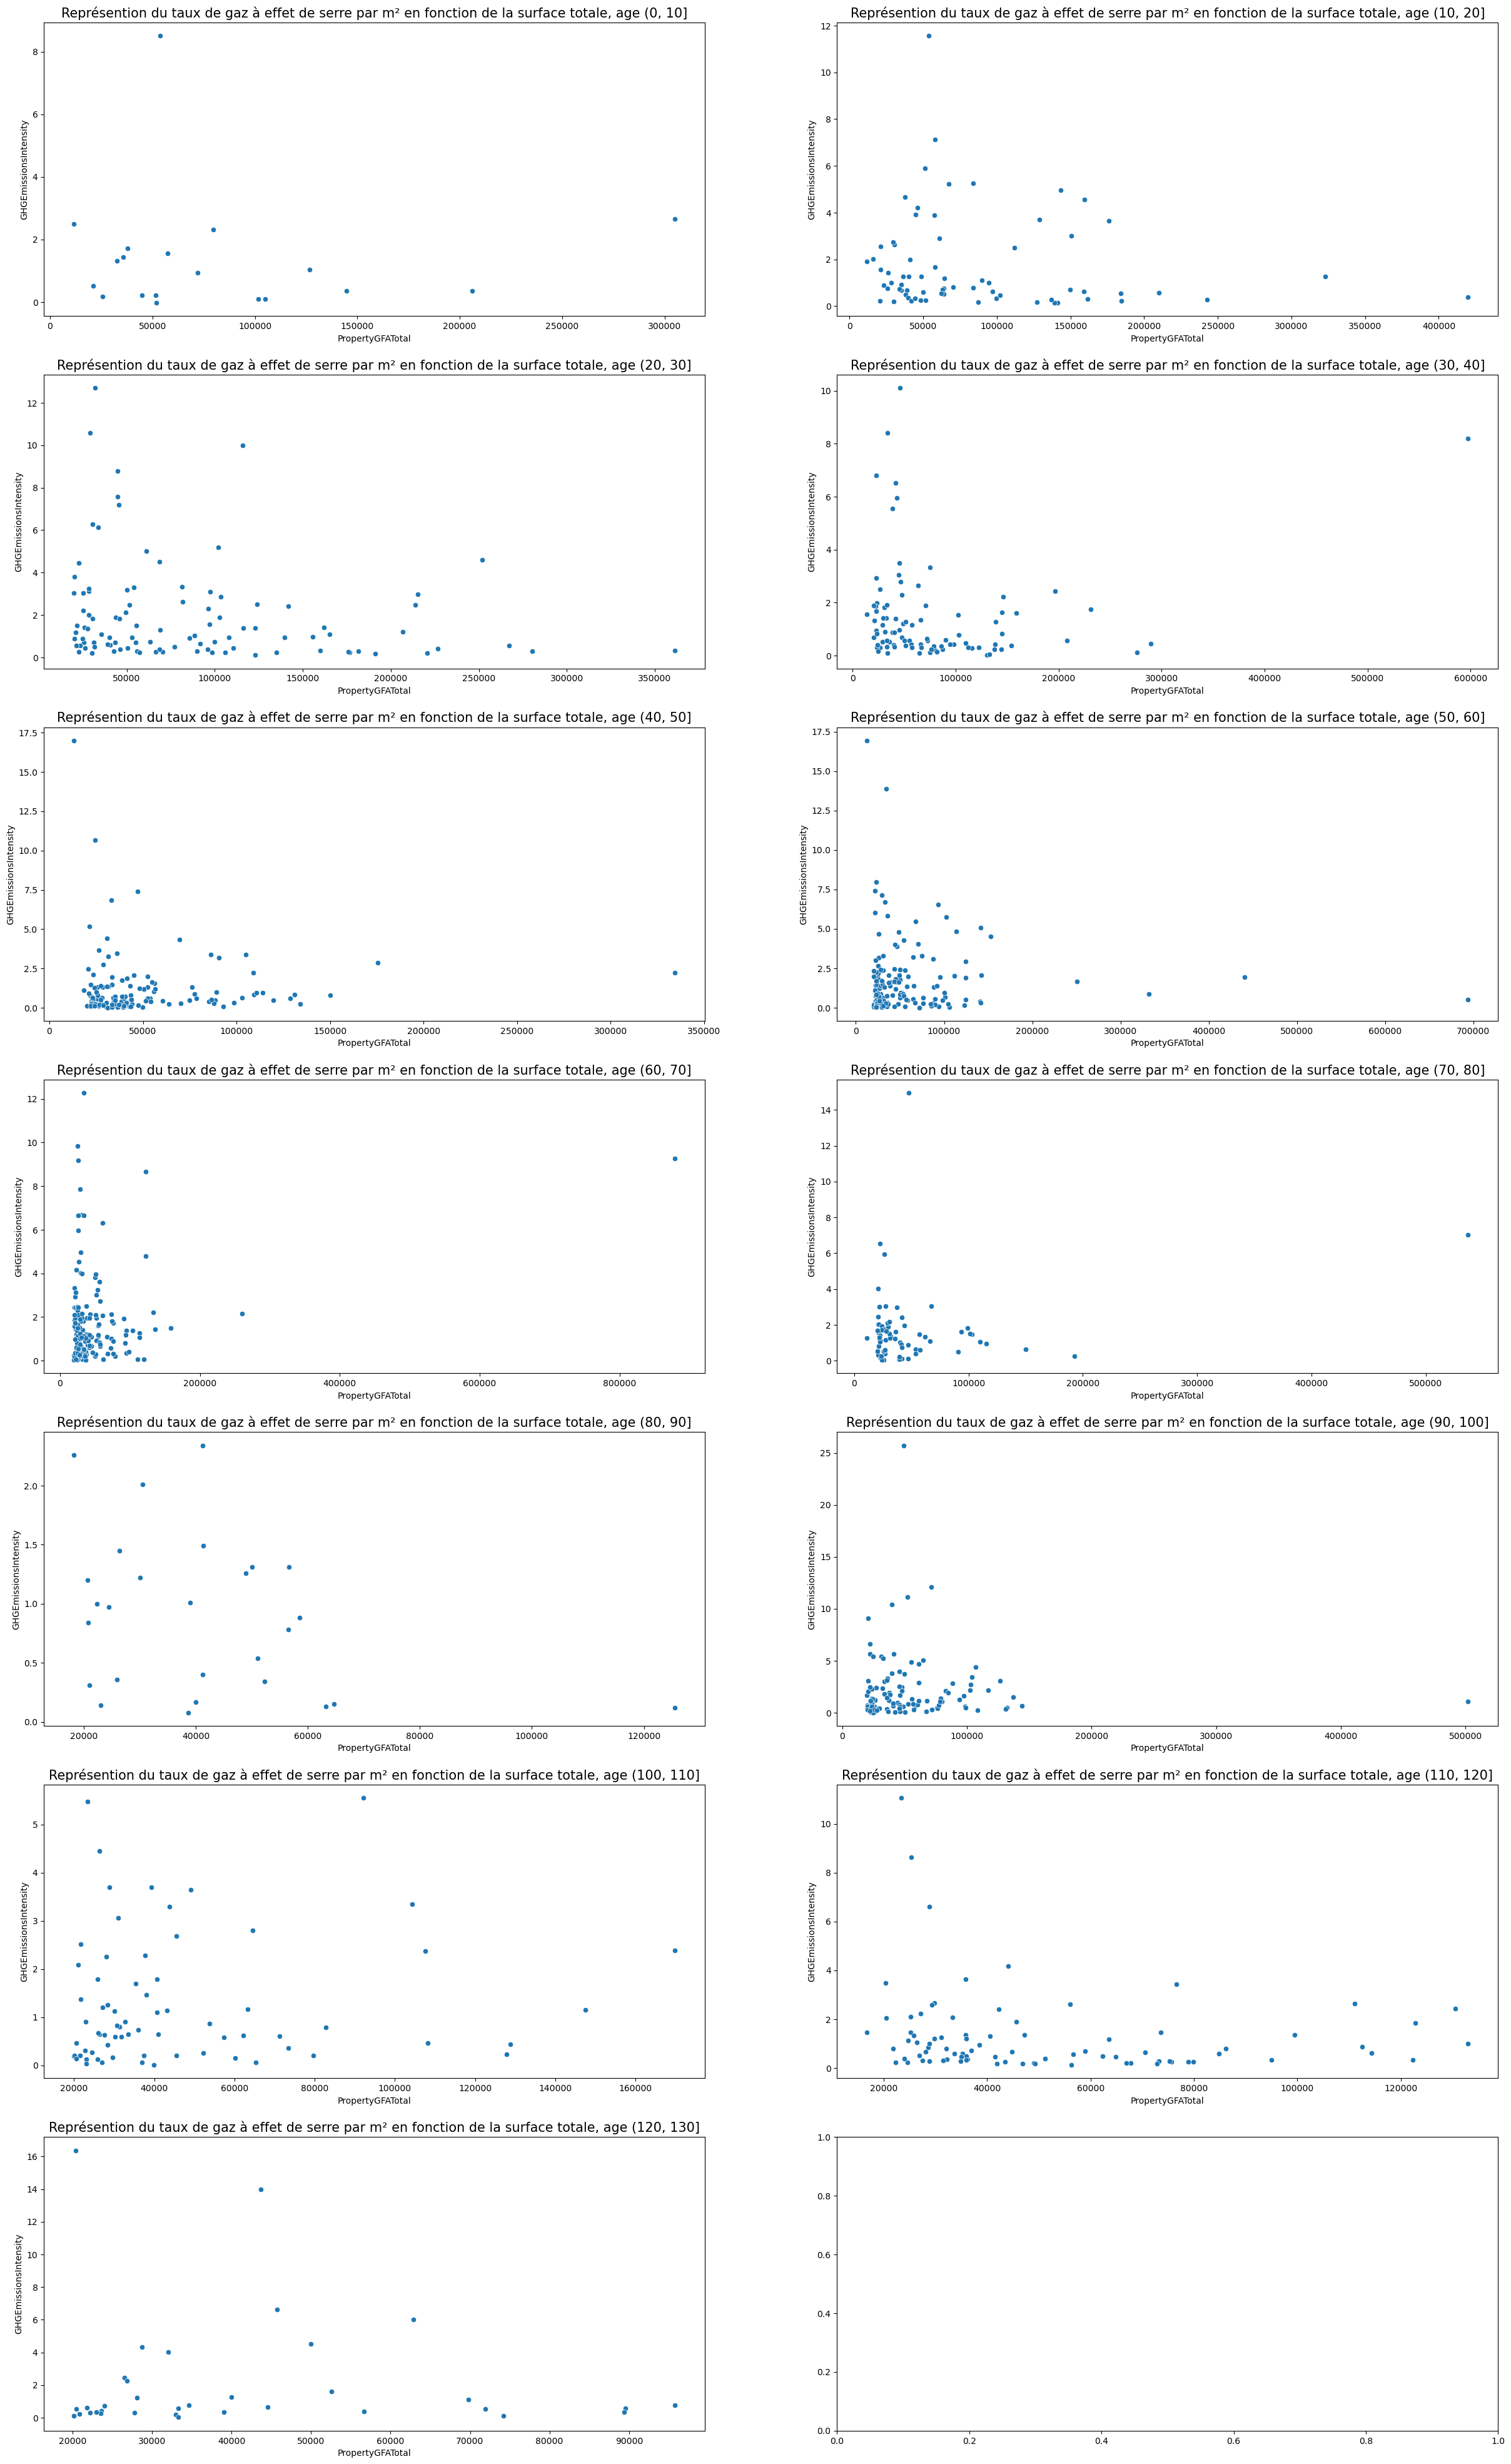

In [124]:
fig, axes = plt.subplots(7, 2,figsize=(30, 50))
axes = axes.ravel()

for age, ax in zip(ages, axes):
    a = sns.scatterplot(df.loc[df['AgeRangeBuilt']==str(age),'PropertyGFATotal'],df.loc[df['AgeRangeBuilt']==str(age),'GHGEmissionsIntensity'],ax=ax)
    a.axes.set_title('Représention du taux de gaz à effet de serre par m² en fonction de la surface totale, age '+age,fontsize=15)

plt.show()

In [125]:
pearson = df.corr(method='pearson')
pearson

Latitude  Longitude  NumberofBuildings  \
Latitude                         1.000000  -0.122825          -0.009231   
Longitude                       -0.122825   1.000000          -0.002989   
NumberofBuildings               -0.009231  -0.002989           1.000000   
NumberofFloors                   0.038242  -0.003478          -0.028790   
PropertyGFATotal                 0.041519   0.023366           0.470292   
PropertyGFAParking               0.096678  -0.017136           0.014737   
PropertyGFABuilding(s)           0.004966   0.035488           0.549924   
LargestPropertyUseTypeGFA        0.038792   0.037402           0.529138   
SecondLargestPropertyUseTypeGFA  0.027129  -0.031272           0.013142   
ThirdLargestPropertyUseTypeGFA  -0.012228   0.011883           0.018508   
ENERGYSTARScore                  0.090125  -0.026762          -0.052520   
SiteEUIWN(kBtu/sf)               0.090493  -0.013435           0.052970   
SteamUse(kBtu)                  -0.022559   0.013563          -0.005590   
NaturalGas(kBtu)                 0.047654   0.049185           0.316008   
GHGEmissionsIntensity            0.066398  -0.012929           0.054246   
ParkingGFARate                   0.124177  -0.047904          -0.021255   
BuildingGFARate                 -0.124177   0.047904           0.021255   
GFAPerFloor                     -0.158447   0.062680          -0.036554   

                                 NumberofFloors  PropertyGFATotal  \
Latitude                               0.038242          0.041519   
Longitude                             -0.003478          0.023366   
NumberofBuildings                     -0.028790          0.470292   
NumberofFloors                         1.000000          0.208559   
PropertyGFATotal                       0.208559          1.000000   
PropertyGFAParking                     0.171605          0.563735   
PropertyGFABuilding(s)                 0.168442          0.926037   
LargestPropertyUseTypeGFA              0.180924          0.954236   
SecondLargestPropertyUseTypeGFA        0.149570          0.494638   
ThirdLargestPropertyUseTypeGFA         0.062445          0.222580   
ENERGYSTARScore                        0.090259          0.029199   
SiteEUIWN(kBtu/sf)                     0.006244          0.113146   
SteamUse(kBtu)                         0.169689          0.068342   
NaturalGas(kBtu)                       0.062688          0.586039   
GHGEmissionsIntensity                 -0.024893          0.024791   
ParkingGFARate                         0.164180          0.409524   
BuildingGFARate                       -0.164180         -0.409524   
GFAPerFloor                           -0.210125          0.307594   

                                 PropertyGFAParking  PropertyGFABuilding(s)  \
Latitude                                   0.096678                0.004966   
Longitude                                 -0.017136                0.035488   
NumberofBuildings                          0.014737                0.549924   
NumberofFloors                             0.171605                0.168442   
PropertyGFATotal                           0.563735                0.926037   
PropertyGFAParking                         1.000000                0.210298   
PropertyGFABuilding(s)                     0.210298                1.000000   
LargestPropertyUseTypeGFA                  0.409107                0.942529   
SecondLargestPropertyUseTypeGFA            0.661985                0.282972   
ThirdLargestPropertyUseTypeGFA             0.279723                0.135633   
ENERGYSTARScore                            0.058719                0.011956   
SiteEUIWN(kBtu/sf)                         0.087537                0.094049   
SteamUse(kBtu)                            -0.003800                0.082629   
NaturalGas(kBtu)                           0.042508                0.674237   
GHGEmissionsIntensity                     -0.063233                0.058239   
ParkingGFARate                 

Text(0.5, 1.0, 'Tableau de corrélation de nos variables')

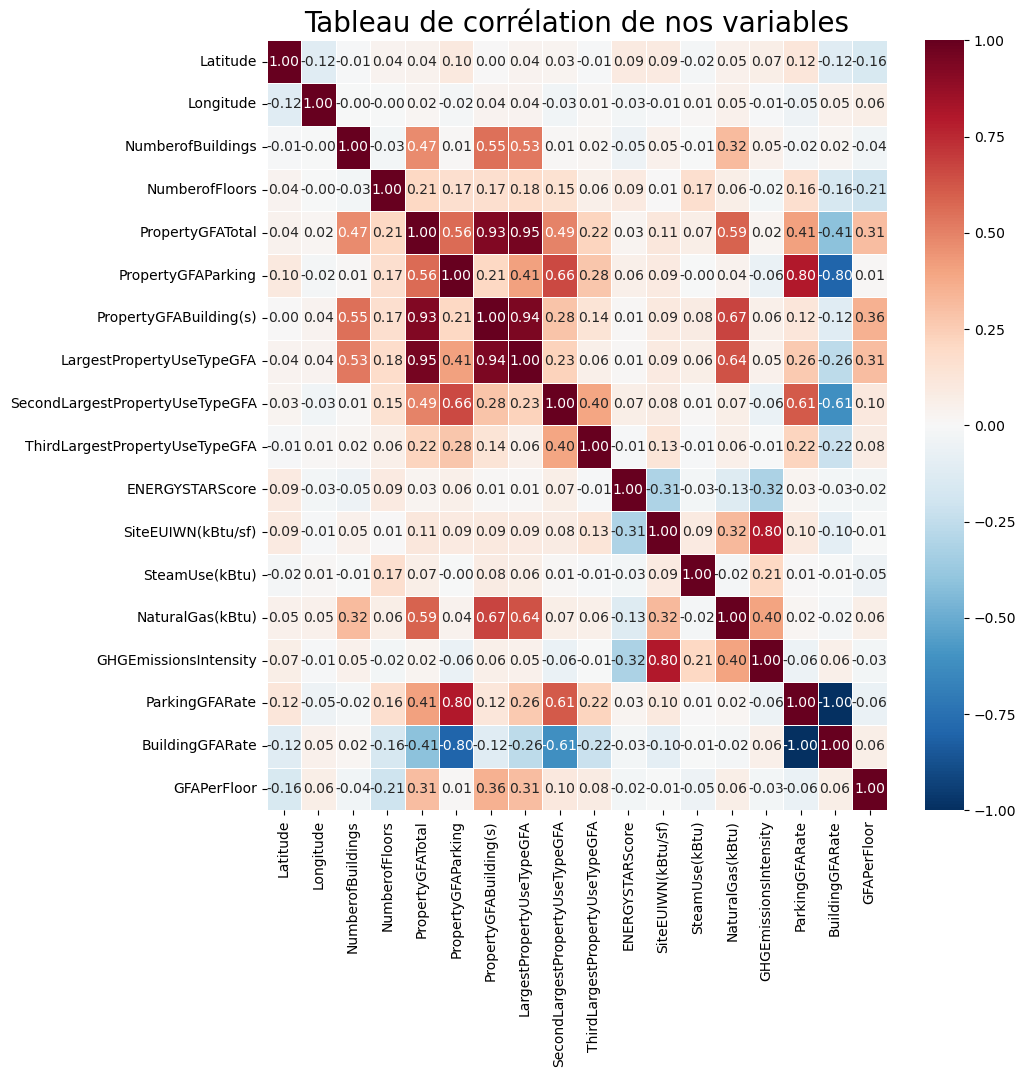

In [130]:
plt.figure(figsize=(10,10))
sns.heatmap(pearson, 
            xticklabels=pearson.columns,
            yticklabels=pearson.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
           fmt='.2f')

plt.title('Tableau de corrélation de nos variables',fontsize=20)

In [119]:
df.to_csv('buildings_nettoyer.csv')